# Install and Import Dependencies

In [1]:
#!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python==4.3.0.36 matplotlib PyQt5

In [2]:
#!pip install keras tensorflow tensorflow-gpu

In [3]:
#!pip freeze > 'requirements.txt'

In [4]:
import os
from os.path import isfile, join
import time
import zipfile
import random

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2

In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [6]:
import tensorflow as tf
#gpus = tf.config.experimental.list_physical_devices('GPU')
#if gpus:
    # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
#    try:
#        tf.config.experimental.set_virtual_device_configuration(
#            gpus[0],
#            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
#        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
#        print(e)
    

2022-05-22 13:25:21.527647: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [7]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D , MaxPooling1D , LSTM, TimeDistributed, Flatten
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Load Model
To perform keypoint detection, I'm going to be using the MoveNet model. MoveNet has two variants:
<br><b> MoveNet Lightning </b>- lower capacity model that can run >50FPS on most modern laptops
<br><b> MoveNet Thunder </b>- higher capacity model that performs better prediction quality while still achieving real-time >30FPS speed
<p> Here, I decided to use MoveNet Thunder to get better performance.</p>

### How the Model Works:
MoveNet was first introduced in May, 2021. MoveNet is a Bottom-up estimation model. This means that it detects all parts in the image (i.e. parts of every person), and then it associates/groups parts belonging to each distinct person. This is in contrast to the Top-Down approach which incorporates a person detector first, then estimates the parts and calculates the pose for each person.
<p>To get the keypoints, the model first feeds the image through an attached feature pyramid network (FPN), which generates a high resolution, semantically rich feature map output. This output is then fed through four prediction heads, which are computed in parallel. </p>

#### How the Prediction Heads Work:
<li><b> Person center heatmap: </b> predicts the geometric center of person instances</li>
<li><b> Keypoint regression field: </b> predicts the full set of keypoints for a person, used for grouping keypoints into instances </li>
<li><b> Person keypoint heatmap: </b> predicts the location of all keypoints, independent of person instances</li>
<li><b> 2D per-keypoint offset field: </b> predicts local offsets from each output feature map pixel to the precise sub-pixel location of each keypoint

In [8]:
model_path = 'lite-model_movenet_singlepose_thunder_3.tflite'
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

In [9]:
if "thunder" in model_path:
    MoveNet_input_size = 256
elif "lightning" in model_path:
    MoveNet_input_size = 192

In [10]:
# reading the photo with matplotlib
photo = plt.imread("img.jpg")
plt.imshow(photo)
plt.axis('off')
plt.show()

In [11]:
# reading the photo with openCV and displaying with matplotlib
img = cv2.imread("img.jpg")

In [12]:
scale_percent = 10 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)

In [13]:
small_img = cv2.resize(img,dim,interpolation=cv2.INTER_AREA )

In [14]:
small_img = cv2.cvtColor(small_img, cv2.COLOR_BGR2RGB)

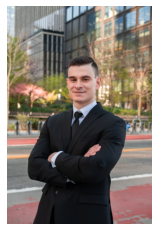

In [15]:
plt.imshow(small_img)
plt.axis('off')
plt.show()

In [16]:
small_img.shape

(624, 416, 3)

In [17]:
small_img.min()

0

# Performing Keypoint Detection from Picture
First, I'm going to test out the model by trying it on a picture. Here are the steps to do this:
<li> Resize the picture so that it is of the proper size to feed into the MoveNet model. (256x256x3 for the Thunder model, 192x192x3 for the Lightning Model)</li>
<li> get the keypoints and plot on the picture </li>
<li> get the connections between the keypoints and plot on the picture </li>

In [19]:
# resizing the image to the correct size for MoveNet, converting to int to be displayed as image
input_image = tf.image.resize_with_pad(small_img, MoveNet_input_size,MoveNet_input_size,antialias=True).numpy().astype(int)

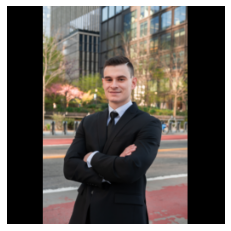

In [20]:
# display image
plt.imshow(input_image)
plt.axis('off')
plt.show()

In [21]:
# Setup input and output 
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Make predictions 
# changing the input image back to float 32 and adding the first dimension to feed into the interpreter
input_image = tf.cast(input_image, dtype=tf.float32)
input_image = np.expand_dims(input_image,axis=0)
interpreter.set_tensor(input_details[0]['index'], np.array(input_image))
# invoking the prediction
interpreter.invoke()
# getting the output details
keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
print(keypoints_with_scores)

[[[[0.36657995 0.48858103 0.8541897 ]
   [0.33644235 0.5225408  0.9347897 ]
   [0.33654383 0.46430033 0.83651364]
   [0.3539041  0.57735354 0.8088476 ]
   [0.3568456  0.4438662  0.802696  ]
   [0.5275999  0.6696951  0.6936908 ]
   [0.5232104  0.367917   0.92842776]
   [0.74716645 0.57206947 0.5899532 ]
   [0.7397003  0.27795964 0.8469997 ]
   [0.69495076 0.36746687 0.5718458 ]
   [0.7373053  0.43579543 0.17094961]
   [0.96758634 0.55595195 0.5053862 ]
   [0.94647425 0.37456566 0.39055443]
   [0.762286   0.5691058  0.01317182]
   [0.7493736  0.2760275  0.02494413]
   [0.9934719  0.30821025 0.00423992]
   [0.99498385 0.3169747  0.02114069]]]]


In [22]:
# specifically identifying the right eye and right shoulder
# these are represented as fractions of the image
right_eye = keypoints_with_scores[0][0][2]
right_shoulder = keypoints_with_scores[0][0][6]

In [23]:
# converting the fractions of the image to actual pixel values by multiplying by height and width
right_eye_coordinates = np.array(right_eye[:2]*[MoveNet_input_size,MoveNet_input_size]).astype(int)
right_shoulder_coordinates = np.array(right_shoulder[:2]*[MoveNet_input_size,MoveNet_input_size]).astype(int)

In [24]:
# reformatting image to remove the first dimension and convert to type int
new_rgb_image = np.array(np.squeeze(input_image)).astype(int)

In [25]:
# marking the right eye on the image
new_rgb_image[right_eye_coordinates[0]-3:right_eye_coordinates[0]+3,
              right_eye_coordinates[1]-3:right_eye_coordinates[1]+3] = [0,255,0]

In [26]:
# marking the right shoulder on the image
new_rgb_image[right_shoulder_coordinates[0]-3:right_shoulder_coordinates[0]+3,
              right_shoulder_coordinates[1]-3:right_shoulder_coordinates[1]+3] = [0,255,0]

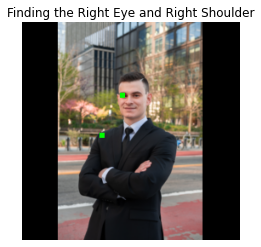

In [27]:
# display image
plt.imshow(new_rgb_image)
plt.axis('off')
plt.title('Finding the Right Eye and Right Shoulder')
plt.show()

In [28]:
# writing function to be able to draw all of the keypoints
def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    # multiplying all of the keypoints to change them from fractions to actual coordinates
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        # draws each keypoint if it is above the threshold
        if kp_conf > confidence_threshold:
            # converts the float values to ints to display result
            cv2.circle(frame, (int(kx), int(ky)), 4, (0,255,0), -1) 

In [29]:
draw_keypoints(np.squeeze(input_image),keypoints_with_scores,0.3)

In [30]:
# display image
plt.imshow(np.squeeze(input_image).astype(int))
plt.axis('off')
plt.title('Drawing All Keypoints')
plt.show()

In [31]:
# writing the function to draw the connections between keypoints
def draw_connections(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)

In [32]:
EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

In [33]:
draw_connections(np.squeeze(input_image),keypoints_with_scores,EDGES,0.3)

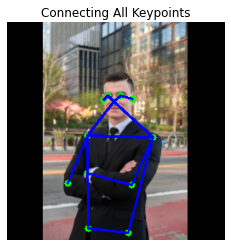

In [34]:
# display image
plt.imshow(np.squeeze(input_image).astype(int))
plt.axis('off')
plt.title('Connecting All Keypoints')
plt.show()

# Putting the Pieces Together in Video Capture

In [35]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    # Reshape image
    img = frame.copy()
    img = tf.image.resize_with_pad(np.expand_dims(img, axis=0), MoveNet_input_size,MoveNet_input_size)
    input_image = tf.cast(img, dtype=tf.float32)
    
    # Setup input and output 
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Make predictions 
    # setting the input details to be the input_image
    interpreter.set_tensor(input_details[0]['index'], np.array(input_image))
    # invoking the prediction
    interpreter.invoke()
    # getting the output details
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    #print(keypoints_with_scores)
    
    # Rendering 
    draw_connections(frame, keypoints_with_scores, EDGES, 0.4)
    #draw_keypoints(frame, keypoints_with_scores, 0.4)
    
    cv2.imshow('MoveNet', frame)
   
    if cv2.waitKey(10) & 0xFF==ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

# Reading Images into a Video
I'm going to be using the upFall dataset which can be found here: http://fenix.univ.rzeszow.pl/~mkepski/ds/uf.html
<p> Here is the citation for the Dataset:
<br> Bogdan Kwolek, Michal Kepski, Human fall detection on embedded platform using depth maps and wireless accelerometer, Computer Methods and Programs in Biomedicine, Volume 117, Issue 3, December 2014, Pages 489-501, ISSN 0169-2607
<p>
The dataset consists of 30 videos of a person falling - "Fall sequences", and 40 videos of a person in activities of daily living  - "ADL sequences". This data is in the format of zip files which contain sequences of images.

### First, Unzip all of the Files
The dataset contains a bunch of zip folders. Each zip folder contains a bunch of images. Those images, when put together in order, generate a video. The videos were taken at 30fps. First, I want to automate the unzipping of all the folders and put them into a directory.

In [36]:
def make_directory_if_doesnt_exist(Directory_Name):
    try:
        # Create  Directory  MyDirectory 
        os.mkdir(Directory_Name)
        #print if directory created successfully...
        print("Directory " , Directory_Name ,  " Created") 
    except FileExistsError:
        ##print if directory already exists...
        print("Directory " , Directory_Name ,  " already exists...")

In [37]:
# first unzip all of the files
def unzip_all_files(directory_containing_zip_files, directory_to_extract_to):
    make_directory_if_doesnt_exist(directory_to_extract_to)
    all_zipped_files = os.listdir(directory_containing_zip_files)
    for zip_file_name in all_zipped_files:
        path_to_zip_file = os.path.join(directory_containing_zip_files, zip_file_name)
        #print(f'unzipping:\t{os.path.join(directory_containing_zip_files,zip_file_name)}')
        with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
            zip_ref.extractall(directory_to_extract_to)

In [38]:
# unzipping all of the FALL photo sequences
directory_containing_zip_files = "UpFall Dataset/fall zip photo files"
directory_to_extract_to = "UpFall Dataset/fall unzip photo files/"
unzip_all_files(directory_containing_zip_files,directory_to_extract_to)

In [39]:
# unzipping all of the Activities of Daily Living (ADL) sequences
directory_containing_zip_files = "UpFall Dataset/adl zip photo files"
directory_to_extract_to = "UpFall Dataset/adl unzip photo files/"
unzip_all_files(directory_containing_zip_files,directory_to_extract_to)

### Next, Convert the Images to Video
Here I am putting the images together in each folder to generate a .mp4 video

In [40]:
def convert_frames_to_video(pathIn,pathOut,fps):
    frame_array = []
    files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
    files.sort(key = lambda a : a.split('-')[-1][:3])
    for i in range(len(files)):
        filename=os.path.join(pathIn, files[i])
        
        #reading each files
        img = cv2.imread(filename)
        # resizing the image to the correct size for MoveNet, converting to int to be displayed as image
        # not going to resize here because I will do it later
        img = tf.image.resize_with_pad(img, MoveNet_input_size,MoveNet_input_size,antialias=True).numpy().astype(int)
        height, width, layers = img.shape
        size = (width,height)

        #print(filename)
        #print(height)
        frame_array.append(img)
    out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'mp4v'), fps, size)
    for i in range(len(frame_array)):
        # writing to a image array
        out.write(frame_array[i].astype('uint8'))
    out.release()

In [41]:
def make_all_videos_in_folder(folder_in, folder_out, fps):
    make_directory_if_doesnt_exist(folder_out)
    for file in os.listdir(folder_in):
        pathIn = os.path.join(folder_in,file)
        pathOut = os.path.join(folder_out,file+".mp4")
        #print(f'generating: \t {pathOut}')
        convert_frames_to_video(pathIn,pathOut,fps)

In [42]:
# making videos from all of the FALL photo sequences
folder_in = "UpFall Dataset/fall unzip photo files"
folder_out = "UpFall Dataset/fall video files"
fps = 7
make_all_videos_in_folder(folder_in, folder_out, fps)

In [43]:
# making videos from all of the Activities of Daily Living (ADL) photo sequences
folder_in = "UpFall Dataset/adl unzip photo files"
folder_out = "UpFall Dataset/adl video files"
fps = 7
make_all_videos_in_folder(folder_in, folder_out, fps)

# Loading Dataframes with Labels for the Videos
Extracted features from depth maps are stored in CSV format. Each row contains one sample of data corresponding to one depth image. The columns from left to right are organized as follows:
<br><b> sequence name </b> - camera name is omitted, because all of the samples are from the front camera ('fall-01-cam0-d' is 'fall-01', 'adl-01-cam0-d' is 'adl-01' and so on), 
<br><b> frame number </b> - corresponding to number in sequence, 
<br><b> label </b>- describes human posture in the depth frame; '-1' means person is not lying, '1' means person is lying on the ground; '0' is temporary pose, when person "is falling", we don't use '0' frames in classification, 
<br><b> HeightWidthRatio </b>- bounding box height to width ratio,
<br><b>  MajorMinorRatio </b>- major to minor axis ratio, computed from BLOB of segmented person,
<br><b>  BoundingBoxOccupancy </b>- ratio of how bounding box is occupied by person's pixels,
<br><b>  MaxStdXZ </b>- standard deviation of pixels from the centroid for the abscissa (X axis) and the depth (Z axis), respectively (it is computed on segmented person transformed to the 3D point cloud),
<br><b>  HHmaxRatio </b>- human height in frame to human height while standing ratio,
<br><b>  H </b>- actual height (in mm),
<br><b>  D </b>- distance of person center to the floor (in mm),
<br><b>  P40 </b>- ratio of the number of the point clouds belonging to the cuboid of 40 cm height and placed on the floor to the number of the point clouds belonging to the cuboid of height equal to person's height.

In [44]:
column_names = ['sequence_name','frame_number','label','HeightWidthRat','MajorMinorRatio','BoundingBoxOccupancy','MaxStdXZ','HHmaxRatio','H','D','P40']

In [45]:
df_adl = pd.read_csv('UpFall Dataset/extracted features/urfall-cam0-adls.csv',names = column_names)

In [46]:
df_falls = pd.read_csv('UpFall Dataset/extracted features/urfall-cam0-falls.csv',names = column_names)

In [47]:
df_falls.head()

sequence_name  frame_number  label  HeightWidthRat  MajorMinorRatio  \
0       fall-01             1     -1          3.1667           2.9098   
1       fall-01             2     -1          3.3067           2.9699   
2       fall-01             3     -1          3.1408           3.0506   
3       fall-01             4     -1          3.4306           3.1435   
4       fall-01             5     -1          3.6324           3.3012   

   BoundingBoxOccupancy  MaxStdXZ  HHmaxRatio          H          D       P40  
0               0.55367  126.0258      1.0324  1899.5366  1055.9988  0.047310  
1               0.47876  125.5657      1.1251  2070.1193  1065.9506  0.048175  
2               0.54374  123.1570      1.0161  1869.6442  1055.4955  0.050180  
3               0.48859  124.5614      1.1251  2070.1193  1076.1464  0.047877  
4               0.49744  123.6089      1.1251  2070.1193  1075.5053  0.052543

In [48]:
df_falls.label.value_counts()

-1    1192
 1     903
 0     900
Name: label, dtype: int64

In [49]:
# this calculates the maximum, minimum, and mean number of frames in each video
df_falls.groupby('sequence_name').count().iloc[:,0].agg(['max','min','mean']).round()

max     215.0
min      55.0
mean    100.0
Name: frame_number, dtype: float64

In [50]:
# this calculates the maximum, minimum, and mean number of frames in each video
df_adl.groupby('sequence_name').count().iloc[:,0].agg(['max','min','mean']).round()

max     369.0
min      70.0
mean    214.0
Name: frame_number, dtype: float64

# Using Keyframe Detection on the Videos

In [156]:
fall_video_dir = "UpFall Dataset/fall video files"
video_link = os.path.join(fall_video_dir,os.listdir(fall_video_dir)[2])
video_link

'UpFall Dataset/fall video files/fall-15-cam0-rgb.mp4'

# READ VIDEO
Here is the base code to be able to read a video

In [47]:
cap = cv2.VideoCapture(video_link)
fps= int(cap.get(cv2.CAP_PROP_FPS))
while(True):
    ret, frame = cap.read()
    if ret == True:
        time.sleep(1/fps)
        cv2.imshow('output',frame)
        if (cv2.waitKey(1) & 0xFF==ord('q')):
            break
    else:
        break
cap.release()
cv2.destroyAllWindows()

# READ AND WRITE VIDEO
Here is the code to read a video and then write the video to a different directory

In [60]:
output_video_directory = 'UpFall Dataset/fall video files with keypoints'

In [63]:
cap = cv2.VideoCapture(video_link)
fps= int(cap.get(cv2.CAP_PROP_FPS))

# We need to set resolutions.
# so, convert them from float to integer.
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

print(frame_width)
print(frame_height)
size = (frame_width, frame_height)

fourcc = cv2.VideoWriter_fourcc(*'MP4V')
result = cv2.VideoWriter(os.path.join(output_video_directory,os.path.basename(video_link)), fourcc, fps, size)

while(True):
    ret, frame = cap.read()
    if ret == True:
        time.sleep(1/fps)
        result.write(frame)
        cv2.imshow('output',frame)
        if (cv2.waitKey(1) & 0xFF==ord('q')):
            break
    else:
        break
cap.release()
result.release()
cv2.destroyAllWindows()


192
192


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


# READ, SHOW VIDEO WITH KEYPOINTS, SAVE VIDEO WITH KEYPOINTS
Here is the code to be able to read the video, generate keypoints, plot the keypoints on the video, and show the video.

In [52]:
output_video_directory = 'UpFall Dataset/fall video files with keypoints'

In [53]:
cap = cv2.VideoCapture(video_link)
fps= int(cap.get(cv2.CAP_PROP_FPS))

### We need to set resolutions.
### so, convert them from float to integer.
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

print(frame_width)
print(frame_height)
size = (frame_width, frame_height)

fourcc = cv2.VideoWriter_fourcc(*'MP4V')
result = cv2.VideoWriter(os.path.join(output_video_directory,os.path.basename(video_link)), fourcc, fps, size)

while(True):
    ret, frame = cap.read()
    if ret == True:
        #############
        # Reshape image
        img = frame.copy()
        # don't need to resize since the videos have already been resized
        img = np.expand_dims(img, axis=0)
        #img = tf.image.resize_with_pad(np.expand_dims(img, axis=0), MoveNet_input_size,MoveNet_input_size)
        input_image = tf.cast(img, dtype=tf.float32)

        # Setup input and output 
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()

        # Make predictions 
        # setting the input details to be the input_image
        interpreter.set_tensor(input_details[0]['index'], np.array(input_image))
        # invoking the prediction
        interpreter.invoke()
        # getting the output details
        keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
        #print(keypoints_with_scores)

        # Rendering 
        draw_connections(frame, keypoints_with_scores, EDGES, 0.1)
        #############
        time.sleep(1/fps)
        result.write(frame)
        cv2.imshow('output',frame)
        if (cv2.waitKey(1) & 0xFF==ord('q')):
            break
    else:
        break
cap.release()
result.release()
cv2.destroyAllWindows()

# Draw Keypoints for All Videos
Here is the code for reading all of the vidoes, generating the keypoints for the videos and plotting them on the videos, then saving those videos.

In [171]:
def add_keypoint_to_video(video_link,output_video_directory):
    cap = cv2.VideoCapture(video_link)
    fps= int(cap.get(cv2.CAP_PROP_FPS))

    # We need to set resolutions.
    # so, convert them from float to integer.
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))

    print(frame_width)
    print(frame_height)
    size = (frame_width, frame_height)

    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    result = cv2.VideoWriter(os.path.join(output_video_directory,os.path.basename(video_link)), fourcc, fps, size)
    while(True):
        ret, frame = cap.read()
        if ret == True:
            #############
            # Reshape image
            img = frame.copy()
            # don't need to resize since the videos have already been resized
            img = np.expand_dims(img, axis=0)
            #img = tf.image.resize_with_pad(np.expand_dims(img, axis=0), MoveNet_input_size,MoveNet_input_size)
            input_image = tf.cast(img, dtype=tf.float32)

            # Setup input and output 
            input_details = interpreter.get_input_details()
            output_details = interpreter.get_output_details()

            # Make predictions 
            # setting the input details to be the input_image
            interpreter.set_tensor(input_details[0]['index'], np.array(input_image))
            # invoking the prediction
            interpreter.invoke()
            # getting the output details
            keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
            #print(keypoints_with_scores)

            # Rendering 
            draw_connections(frame, keypoints_with_scores, EDGES, 0.1)
            #############
            result.write(frame)

                
            #cv2.imshow('output',frame)
            if (cv2.waitKey(1) & 0xFF==ord('q')):
                break
        else:
            break
    cap.release()
    result.release()
    cv2.destroyAllWindows()

In [172]:
output_video_directory = 'UpFall Dataset/fall video files with keypoints'

In [173]:
fall_video_dir = "UpFall Dataset/fall video files"
video_list = [os.path.join(fall_video_dir,vid) for vid in os.listdir(fall_video_dir)]
video_list[:3]

['UpFall Dataset/fall video files/fall-16-cam0-rgb.mp4',
 'UpFall Dataset/fall video files/fall-09-cam0-rgb.mp4',
 'UpFall Dataset/fall video files/fall-15-cam0-rgb.mp4']

In [1]:
for video_link in video_list:
    add_keypoint_to_video(video_link,output_video_directory)

# Draw Keypoints for All Videos and Save Every 'x' Frames
I wanted to be able to see some of the keypoints on the videos within the Jupyter Notebook, so in this code I generated the keypoints for the videos then I saved every 'x' frames, so that I could plot them below

In [399]:
def add_keypoint_to_video_and_save_frames(video_link,output_video_directory,output_frame_directory,save_per_x_frame):
    cap = cv2.VideoCapture(video_link)
    fps= int(cap.get(cv2.CAP_PROP_FPS))

    # We need to set resolutions.
    # so, convert them from float to integer.
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))

    print(frame_width)
    print(frame_height)
    size = (frame_width, frame_height)

    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    result = cv2.VideoWriter(os.path.join(output_video_directory,os.path.basename(video_link)), fourcc, fps, size)
    # the frames are 1-indexed, so start the count at 1
    count = 1
    while(True):
        ret, frame = cap.read()
        if ret == True:
            #############
            # Reshape image
            img = frame.copy()
            # don't need to resize since the videos have already been resized
            img = np.expand_dims(img, axis=0)
            #img = tf.image.resize_with_pad(np.expand_dims(img, axis=0), MoveNet_input_size,MoveNet_input_size)
            input_image = tf.cast(img, dtype=tf.float32)

            # Setup input and output 
            input_details = interpreter.get_input_details()
            output_details = interpreter.get_output_details()

            # Make predictions 
            # setting the input details to be the input_image
            interpreter.set_tensor(input_details[0]['index'], np.array(input_image))
            # invoking the prediction
            interpreter.invoke()
            # getting the output details
            keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
            print(keypoints_with_scores)

            # Rendering 
            draw_connections(frame, keypoints_with_scores, EDGES, 0.1)
            #############
            result.write(frame)
            # saving every 'x' frames
            if count %save_per_x_frame == 0:
                # creating a subfolder for each video
                output_frame_subfolder = os.path.join(output_frame_directory,os.path.basename(video_link).split('.')[0])
                # make the folder if it doesn't already exist
                make_directory_if_doesnt_exist(output_frame_subfolder)
                # generate the full path to save the photo
                path_to_save_frames = os.path.join(output_frame_subfolder,os.path.basename(video_link).split('.')[0]+'_frame'+str(count)+'.jpg')
                # save the photo
                cv2.imwrite(path_to_save_frames,frame)
            #cv2.imshow('output',frame)
            count += 1
            if (cv2.waitKey(1) & 0xFF==ord('q')):
                break
        else:
            break
    cap.release()
    result.release()
    cv2.destroyAllWindows()

In [400]:
# where to output the videos
output_video_directory = 'UpFall Dataset/fall video files with keypoints'

In [401]:
# save each 'x' fframes
save_per_x_frame = 10

In [402]:
fall_image_with_keypoints_dir = "UpFall Dataset/fall image with keypoint files"
make_directory_if_doesnt_exist(fall_image_with_keypoints_dir)

Directory  UpFall Dataset/fall image with keypoint files  already exists...


In [403]:
# getting hte list of input videos
fall_video_dir = "UpFall Dataset/fall video files"
video_list = [os.path.join(fall_video_dir,vid) for vid in os.listdir(fall_video_dir)]
video_list[:2]

['UpFall Dataset/fall video files/fall-16-cam0-rgb.mp4',
 'UpFall Dataset/fall video files/fall-09-cam0-rgb.mp4']

In [404]:
num_videos_to_get_still_images_from = 8

In [405]:
# generating the keypoints for each of the videos
for video_link in video_list[:num_videos_to_get_still_images_from]:
    add_keypoint_to_video_and_save_frames(video_link,output_video_directory,fall_image_with_keypoints_dir,save_per_x_frame)

256
256
[[[[0.4919262  0.7165938  0.48068663]
   [0.47739822 0.7169154  0.5800764 ]
   [0.47621214 0.7096311  0.45185998]
   [0.46536252 0.746942   0.537463  ]
   [0.47056898 0.7308371  0.17081034]
   [0.51291406 0.79548585 0.34081274]
   [0.511209   0.7754564  0.52457404]
   [0.59010035 0.82654864 0.35287583]
   [0.5825276  0.780153   0.2948184 ]
   [0.63482815 0.77469754 0.36670876]
   [0.62690175 0.75485885 0.3453018 ]
   [0.6480575  0.8233976  0.53968656]
   [0.64080685 0.8117553  0.5417099 ]
   [0.6823058  0.66305625 0.5860303 ]
   [0.67692524 0.66534144 0.5785737 ]
   [0.7976819  0.7520341  0.41631165]
   [0.7985193  0.7426199  0.3650881 ]]]]
[[[[0.49578246 0.7134138  0.46470812]
   [0.48118588 0.713929   0.56762856]
   [0.47999838 0.70763546 0.40708482]
   [0.46936908 0.73819    0.55602247]
   [0.47364664 0.7285575  0.20442379]
   [0.5124512  0.79348123 0.3728694 ]
   [0.51116973 0.77436    0.5234733 ]
   [0.588549   0.82920223 0.32536286]
   [0.58110046 0.7817055  0.26671505]
 

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


[[[[0.5147775  0.6752594  0.48607674]
   [0.5013405  0.6769182  0.40630788]
   [0.50273776 0.67169696 0.30339152]
   [0.48482606 0.6997076  0.37365484]
   [0.49187353 0.6895172  0.29366684]
   [0.5210836  0.7639244  0.47076413]
   [0.5274505  0.7324428  0.47659963]
   [0.59028494 0.8149677  0.4976801 ]
   [0.5920821  0.7542837  0.2976486 ]
   [0.6480504  0.7497329  0.28138572]
   [0.64254946 0.730267   0.34136832]
   [0.65379244 0.82345486 0.40652198]
   [0.6508029  0.8085259  0.49798352]
   [0.69162303 0.6587697  0.45698425]
   [0.682477   0.6566083  0.44222116]
   [0.82073325 0.7466369  0.5107823 ]
   [0.8123134  0.7455472  0.2787419 ]]]]
Directory  UpFall Dataset/fall image with keypoint files/fall-16-cam0-rgb  Created
[[[[0.51524544 0.6672257  0.44916683]
   [0.50125074 0.66927123 0.44551125]
   [0.5034646  0.66269565 0.36466113]
   [0.48615503 0.69021684 0.59248036]
   [0.4937314  0.68020636 0.35277575]
   [0.518662   0.74992955 0.37551188]
   [0.52947015 0.7229213  0.5436941 ]
  

[[[[0.5939744  0.5267009  0.54621595]
   [0.5800395  0.5245954  0.62138236]
   [0.58277994 0.5230943  0.67108107]
   [0.55403656 0.5345743  0.70847017]
   [0.5589887  0.53232825 0.52340066]
   [0.5588417  0.5882835  0.69508165]
   [0.57062024 0.58143044 0.54999804]
   [0.62408596 0.6371727  0.26400292]
   [0.6479317  0.6080231  0.3441475 ]
   [0.6763374  0.62887895 0.26711094]
   [0.6925107  0.58322185 0.42070597]
   [0.63573647 0.763969   0.6527905 ]
   [0.6439854  0.749711   0.616446  ]
   [0.72137773 0.6456847  0.41626516]
   [0.73078394 0.6341423  0.40859988]
   [0.809432   0.73489183 0.6038766 ]
   [0.81730014 0.72271854 0.54311985]]]]
Directory  UpFall Dataset/fall image with keypoint files/fall-16-cam0-rgb  already exists...
[[[[0.5985799  0.51756245 0.5826801 ]
   [0.5860515  0.51373506 0.70109665]
   [0.5886242  0.5119018  0.6209172 ]
   [0.55908716 0.528632   0.621749  ]
   [0.56119716 0.52463347 0.48550713]
   [0.55951697 0.5758556  0.48938516]
   [0.5717486  0.572595   0.50

[[[[0.7925423  0.38879815 0.3354078 ]
   [0.79524285 0.3843811  0.36090842]
   [0.7944148  0.3805413  0.34086418]
   [0.8004952  0.38837638 0.23304531]
   [0.79806364 0.37555113 0.26971442]
   [0.8112176  0.4630097  0.25463068]
   [0.7702691  0.394107   0.35729304]
   [0.7152892  0.5242935  0.3384068 ]
   [0.7456181  0.40145946 0.10951537]
   [0.73681223 0.46344307 0.26477545]
   [0.7445715  0.3979608  0.24512157]
   [0.74769545 0.5630481  0.23545358]
   [0.7341753  0.5537136  0.34244555]
   [0.8372429  0.5277857  0.51626277]
   [0.82409954 0.5258196  0.38766748]
   [0.8083166  0.658205   0.55090606]
   [0.78136325 0.5537534  0.21233183]]]]
Directory  UpFall Dataset/fall image with keypoint files/fall-16-cam0-rgb  already exists...
[[[[0.79918057 0.38090146 0.3346025 ]
   [0.802488   0.37857035 0.4085315 ]
   [0.79971343 0.37193385 0.27016687]
   [0.80908227 0.39090508 0.3514369 ]
   [0.8028863  0.37371746 0.19814041]
   [0.816823   0.46461833 0.23915476]
   [0.7729653  0.40225995 0.27

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


[[[[0.30199265 0.5811852  0.5371063 ]
   [0.29208556 0.5861522  0.7006996 ]
   [0.29517996 0.57352626 0.57912236]
   [0.29733407 0.6012359  0.5895363 ]
   [0.30205286 0.56666017 0.5503252 ]
   [0.33819395 0.6264522  0.51306236]
   [0.34691706 0.55583835 0.4848062 ]
   [0.38784888 0.65718174 0.40758392]
   [0.39902532 0.55050373 0.4520401 ]
   [0.42770046 0.6221529  0.19583389]
   [0.4367674  0.5472394  0.40062374]
   [0.46965876 0.6126144  0.5866942 ]
   [0.46870172 0.567716   0.63019496]
   [0.56406397 0.61073136 0.45293623]
   [0.5641498  0.5578645  0.64541304]
   [0.65131205 0.6219526  0.468326  ]
   [0.65448254 0.5513783  0.59110254]]]]
[[[[0.30144814 0.5754695  0.40798074]
   [0.2918053  0.5826981  0.67549264]
   [0.29459584 0.5698299  0.64370584]
   [0.29778516 0.5988491  0.56597763]
   [0.30066332 0.5638704  0.457832  ]
   [0.33828136 0.6243502  0.4417088 ]
   [0.3456681  0.55028063 0.4029949 ]
   [0.38935697 0.651792   0.56293136]
   [0.39445856 0.5462406  0.3891356 ]
   [0.440

[[[[0.28331503 0.51231545 0.52516186]
   [0.27056837 0.5164392  0.5933895 ]
   [0.27334133 0.5025461  0.57062554]
   [0.27837354 0.5322365  0.6159854 ]
   [0.2837851  0.4910123  0.4448071 ]
   [0.3317911  0.5659492  0.5194826 ]
   [0.3439608  0.47558817 0.51705545]
   [0.3962443  0.59184736 0.5510399 ]
   [0.41017458 0.45939025 0.6075028 ]
   [0.47785255 0.5960035  0.3399811 ]
   [0.4807043  0.44337887 0.56861156]
   [0.4648198  0.5598617  0.6148857 ]
   [0.46790168 0.5077944  0.59997284]
   [0.57293683 0.5529145  0.6989221 ]
   [0.57903767 0.52015203 0.56842864]
   [0.6768035  0.57765484 0.5065904 ]
   [0.6690115  0.53896403 0.5351878 ]]]]
[[[[0.28246543 0.5084825  0.46457633]
   [0.27067572 0.51356864 0.41703716]
   [0.2727766  0.49867097 0.5632268 ]
   [0.27785257 0.53100944 0.57302004]
   [0.28187388 0.48920766 0.35613793]
   [0.3316143  0.56387126 0.47078213]
   [0.3415865  0.4705994  0.5059759 ]
   [0.39664125 0.5902399  0.5838183 ]
   [0.40548566 0.4567212  0.56127006]
   [0.479

[[[[0.26337656 0.4277139  0.6407429 ]
   [0.25017926 0.437677   0.46036732]
   [0.25242537 0.42648274 0.5309532 ]
   [0.2469373  0.46786952 0.37057012]
   [0.25175437 0.4439424  0.23205137]
   [0.29888883 0.50571436 0.70841336]
   [0.3189924  0.45108208 0.6056809 ]
   [0.38793308 0.54260653 0.5981928 ]
   [0.39811713 0.4500831  0.20983192]
   [0.48537987 0.5188624  0.5626907 ]
   [0.47293088 0.43167618 0.45115024]
   [0.49107185 0.49127027 0.69020367]
   [0.48490354 0.44081762 0.76695824]
   [0.6095417  0.49652207 0.60676676]
   [0.6012109  0.43321463 0.8105639 ]
   [0.7216117  0.52479917 0.7318783 ]
   [0.69799244 0.4678013  0.6920695 ]]]]
[[[[0.266587   0.42386416 0.50653124]
   [0.2515865  0.43452832 0.61525697]
   [0.2549187  0.4245738  0.6038052 ]
   [0.24645911 0.46429485 0.5368771 ]
   [0.25205734 0.4435271  0.309572  ]
   [0.2908002  0.50253004 0.5933102 ]
   [0.3128283  0.4521283  0.51953095]
   [0.3819655  0.54166895 0.6467693 ]
   [0.39206064 0.45801702 0.26381606]
   [0.469

[[[[0.22599222 0.4079058  0.54306626]
   [0.21343459 0.4063229  0.5407198 ]
   [0.2166335  0.39061612 0.49748692]
   [0.22216704 0.39960808 0.43583372]
   [0.22779283 0.35414696 0.77501595]
   [0.29585958 0.44559067 0.5987102 ]
   [0.30637106 0.31363577 0.7055939 ]
   [0.37640038 0.48773125 0.59242874]
   [0.4031827  0.2931361  0.5490114 ]
   [0.44938582 0.53409153 0.5195016 ]
   [0.49018607 0.27561226 0.40674222]
   [0.49760166 0.44917282 0.72092634]
   [0.5039671  0.3675127  0.790375  ]
   [0.6308884  0.47001457 0.8383267 ]
   [0.64601797 0.37922207 0.78502667]
   [0.73639804 0.49636176 0.77131826]
   [0.77141017 0.37976152 0.86828184]]]]
[[[[0.22500545 0.41298747 0.60836846]
   [0.21157378 0.4093329  0.7190908 ]
   [0.21330956 0.39425197 0.59669954]
   [0.22073042 0.39981496 0.4292283 ]
   [0.22633298 0.35720992 0.75566053]
   [0.29512954 0.44423968 0.6571963 ]
   [0.30328122 0.31457007 0.70243394]
   [0.38544092 0.4877373  0.62263864]
   [0.39575517 0.28585815 0.66537917]
   [0.450

[[[[0.21060853 0.41964096 0.5985478 ]
   [0.19565117 0.43574935 0.6460887 ]
   [0.19795147 0.41859475 0.62158275]
   [0.19882543 0.4805587  0.6398061 ]
   [0.20197088 0.44000423 0.28578413]
   [0.27459663 0.53801984 0.87338316]
   [0.28149188 0.40779465 0.6801929 ]
   [0.3954454  0.5781015  0.6977742 ]
   [0.38568595 0.39019176 0.5116727 ]
   [0.4916482  0.5951495  0.7362619 ]
   [0.4741536  0.3739175  0.63099635]
   [0.5079234  0.513921   0.7838079 ]
   [0.5039173  0.42820597 0.8333181 ]
   [0.65904003 0.5328179  0.88142854]
   [0.64752895 0.40720543 0.8905126 ]
   [0.8014217  0.57758754 0.8613558 ]
   [0.7730815  0.3917837  0.6789901 ]]]]
[[[[0.20959394 0.42557505 0.64412   ]
   [0.19407694 0.44025028 0.73977363]
   [0.19672172 0.42503744 0.7183341 ]
   [0.19637844 0.48575205 0.77798784]
   [0.19918951 0.44790068 0.48347375]
   [0.27048475 0.54330856 0.815068  ]
   [0.28024825 0.4141613  0.83468384]
   [0.38928738 0.59015423 0.7171467 ]
   [0.39329016 0.40504742 0.5677062 ]
   [0.489

[[[[0.24490187 0.49184042 0.5437035 ]
   [0.22773446 0.49434152 0.56602186]
   [0.22702776 0.4955317  0.5075358 ]
   [0.22144939 0.51536477 0.6047537 ]
   [0.22188294 0.5208376  0.47443756]
   [0.2597508  0.56844616 0.69846475]
   [0.2628183  0.57160753 0.5029934 ]
   [0.38102138 0.58995295 0.6205177 ]
   [0.38189697 0.5908666  0.46785384]
   [0.47690818 0.5109434  0.4828434 ]
   [0.47716662 0.52078426 0.4959518 ]
   [0.48855364 0.56936216 0.74629796]
   [0.48884296 0.57285863 0.76351583]
   [0.6367106  0.5514261  0.62936825]
   [0.6267306  0.57001364 0.6666127 ]
   [0.8055571  0.57031035 0.63628924]
   [0.73054403 0.60441214 0.3822443 ]]]]
[[[[0.24874708 0.49545443 0.61255175]
   [0.23305987 0.4949575  0.56727123]
   [0.23175146 0.4991947  0.46600607]
   [0.22249618 0.5101407  0.58716094]
   [0.22147612 0.5239682  0.6227549 ]
   [0.26177287 0.5641867  0.70535344]
   [0.26355347 0.57045066 0.6166081 ]
   [0.37918478 0.5897941  0.5121264 ]
   [0.38294157 0.59845185 0.5530952 ]
   [0.474

[[[[0.26993185 0.50637794 0.369022  ]
   [0.2582001  0.50267416 0.45724708]
   [0.25439057 0.5134331  0.24131373]
   [0.2537107  0.5162333  0.48636818]
   [0.24782772 0.55314815 0.49648383]
   [0.30750003 0.5296132  0.6497967 ]
   [0.3004104  0.6028455  0.56202793]
   [0.41289395 0.5159743  0.68590826]
   [0.406878   0.6041497  0.34424514]
   [0.5014375  0.48396385 0.4873316 ]
   [0.47954133 0.559651   0.20767096]
   [0.49469858 0.5585593  0.48238775]
   [0.49376    0.61290854 0.64739335]
   [0.61022645 0.54826343 0.5120659 ]
   [0.6011959  0.5855926  0.6578895 ]
   [0.72584945 0.601305   0.6776892 ]
   [0.72731066 0.61860657 0.45667478]]]]
[[[[0.27801833 0.50028723 0.50755346]
   [0.2654397  0.49759513 0.46999136]
   [0.25859877 0.51078737 0.27135968]
   [0.2612054  0.5111727  0.47346738]
   [0.2531942  0.5505411  0.4848883 ]
   [0.3181099  0.526565   0.58474606]
   [0.30802998 0.5977367  0.6715205 ]
   [0.41805178 0.51017606 0.68816483]
   [0.41197628 0.60772675 0.29851872]
   [0.501

[[[[0.643106   0.29080632 0.35510826]
   [0.63518256 0.2806131  0.36186302]
   [0.6331641  0.27939063 0.43764418]
   [0.6242886  0.30138928 0.4228829 ]
   [0.60762835 0.3048139  0.30900127]
   [0.6418562  0.3563541  0.5307176 ]
   [0.5803291  0.3989619  0.2576238 ]
   [0.7515633  0.41439235 0.46872747]
   [0.68867517 0.4765763  0.12167916]
   [0.8070589  0.34997788 0.56554925]
   [0.7369759  0.4242679  0.14355636]
   [0.6668615  0.5494924  0.3024022 ]
   [0.6110971  0.56767    0.54323465]
   [0.7382542  0.5184559  0.33311516]
   [0.6644856  0.5361851  0.3819207 ]
   [0.746581   0.5682769  0.20056689]
   [0.72083724 0.58593225 0.39110437]]]]
[[[[0.75200385 0.5882848  0.29005313]
   [0.74984896 0.5992951  0.3546731 ]
   [0.751493   0.59460914 0.3800975 ]
   [0.7260963  0.58125174 0.3156032 ]
   [0.7323558  0.572585   0.41400197]
   [0.6740768  0.55168504 0.18083435]
   [0.6909535  0.5201096  0.4226239 ]
   [0.63838404 0.53056246 0.23319519]
   [0.67327136 0.3714422  0.3144005 ]
   [0.765

[[[[0.7781362  0.3295353  0.13388982]
   [0.76865804 0.31768566 0.14039046]
   [0.76819444 0.320513   0.14719576]
   [0.81031394 0.2707302  0.24546713]
   [0.803744   0.3107832  0.08673087]
   [0.8311374  0.34655052 0.09396192]
   [0.8231314  0.34315118 0.13986841]
   [0.8105016  0.4761731  0.2565746 ]
   [0.7411792  0.4120623  0.10514116]
   [0.60340786 0.48182333 0.35026518]
   [0.6597284  0.4699703  0.24182007]
   [0.8154651  0.4377484  0.02577806]
   [0.81451535 0.42627373 0.0412626 ]
   [0.6488529  0.3299402  0.49081036]
   [0.64500785 0.33209273 0.28999233]
   [0.59943384 0.48395693 0.16635251]
   [0.7195164  0.30787146 0.06362179]]]]
[[[[0.823665   0.1612284  0.21456048]
   [0.83473414 0.14668453 0.19170648]
   [0.8312309  0.14833504 0.18421909]
   [0.8555538  0.13214703 0.22987905]
   [0.8547044  0.14709058 0.17664945]
   [0.8619033  0.18422468 0.20151901]
   [0.86432886 0.19544515 0.301384  ]
   [0.8399672  0.39034846 0.0980714 ]
   [0.7425786  0.30018127 0.34884024]
   [0.785

[[[[0.8673279  0.20374969 0.09716931]
   [0.8735916  0.15093222 0.09131286]
   [0.8747652  0.15125681 0.09332517]
   [0.8814214  0.14258324 0.05325368]
   [0.88147587 0.14626543 0.07196239]
   [0.7322625  0.40489766 0.258218  ]
   [0.7239174  0.43116242 0.17659876]
   [0.7686893  0.4264649  0.19327578]
   [0.7336246  0.43430957 0.13348952]
   [0.7755059  0.36899045 0.10277215]
   [0.72719663 0.41822356 0.19966415]
   [0.7519386  0.44403723 0.24961358]
   [0.726413   0.46026307 0.25886187]
   [0.7680137  0.46877626 0.2528106 ]
   [0.7480981  0.49883625 0.1537776 ]
   [0.73123103 0.53938496 0.21433681]
   [0.7150856  0.5390623  0.24815086]]]]
[[[[0.75711524 0.37225902 0.08617267]
   [0.7548056  0.36453852 0.05364081]
   [0.7550244  0.37039402 0.07955784]
   [0.740506   0.36573943 0.07578662]
   [0.7307906  0.40102398 0.1658504 ]
   [0.7449145  0.3774314  0.18562868]
   [0.7328386  0.42659345 0.27934778]
   [0.7680728  0.42295337 0.1320459 ]
   [0.74496365 0.44555882 0.14773816]
   [0.782

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


[[[[0.43206933 0.5993934  0.5227513 ]
   [0.42205483 0.6047056  0.537854  ]
   [0.4251591  0.5915763  0.33366725]
   [0.42419156 0.6128348  0.5377375 ]
   [0.42602903 0.5844791  0.5636718 ]
   [0.4584562  0.63289505 0.58380145]
   [0.4629417  0.57626784 0.6408225 ]
   [0.49709642 0.6660637  0.41964477]
   [0.4998973  0.54823834 0.46062586]
   [0.53438705 0.6353672  0.3275165 ]
   [0.5440925  0.5686783  0.41008937]
   [0.56893337 0.620677   0.48661888]
   [0.56448543 0.5846438  0.57405764]
   [0.6413591  0.61938095 0.48176408]
   [0.63843715 0.58365387 0.5776353 ]
   [0.7075745  0.6242488  0.4440722 ]
   [0.7086591  0.585578   0.56635636]]]]
[[[[0.4303048  0.5926418  0.40644372]
   [0.42112297 0.5986012  0.5389035 ]
   [0.42416838 0.587088   0.48126015]
   [0.42283338 0.6098442  0.41996711]
   [0.42580795 0.5805177  0.44040415]
   [0.45851403 0.63152254 0.5825206 ]
   [0.4620078  0.57455236 0.66215473]
   [0.49320945 0.66615504 0.39917225]
   [0.499531   0.5465584  0.43964592]
   [0.483

[[[[0.43407902 0.5533073  0.48869625]
   [0.4247891  0.55865973 0.5184171 ]
   [0.42692098 0.54507965 0.54579604]
   [0.423357   0.5642027  0.5375511 ]
   [0.43003574 0.5372695  0.52250683]
   [0.45355222 0.5903011  0.34924483]
   [0.46621954 0.5280753  0.5184864 ]
   [0.49057925 0.61813205 0.47935772]
   [0.50959915 0.53083116 0.3075743 ]
   [0.5353451  0.596195   0.28176   ]
   [0.5316014  0.5506592  0.32989472]
   [0.55983686 0.59271276 0.41850317]
   [0.56101894 0.5588871  0.44604042]
   [0.6409079  0.58579934 0.47259766]
   [0.64286095 0.5730111  0.52162504]
   [0.712526   0.58602417 0.4902642 ]
   [0.70908916 0.5813239  0.4681485 ]]]]
[[[[0.4399969  0.5504126  0.46857464]
   [0.4303027  0.5565415  0.590373  ]
   [0.43301642 0.5429918  0.59499   ]
   [0.42784995 0.5643255  0.6118127 ]
   [0.4351185  0.534613   0.48557362]
   [0.45727345 0.58729976 0.52247447]
   [0.4677751  0.5268051  0.49404123]
   [0.49810675 0.61706275 0.5507187 ]
   [0.51662856 0.5261985  0.2825759 ]
   [0.524

[[[[0.70228213 0.43343458 0.22003439]
   [0.71172124 0.437291   0.22292227]
   [0.71118253 0.42509812 0.21747881]
   [0.69771427 0.45651972 0.24599835]
   [0.6896001  0.42507648 0.22754592]
   [0.68210095 0.49447343 0.4038657 ]
   [0.6572054  0.39542443 0.6282482 ]
   [0.76538044 0.5174768  0.2908067 ]
   [0.7256905  0.3783568  0.38910145]
   [0.8545593  0.4935198  0.18150824]
   [0.8470816  0.33557677 0.4948454 ]
   [0.5953235  0.53727025 0.50056714]
   [0.5864651  0.50313586 0.5922327 ]
   [0.70377356 0.5499155  0.2852447 ]
   [0.6860596  0.52116853 0.25704992]
   [0.74902755 0.5480958  0.2214    ]
   [0.7382551  0.5333319  0.21771538]]]]
[[[[0.7154496  0.43330988 0.24709338]
   [0.7194391  0.43522075 0.25401792]
   [0.71745765 0.42480385 0.34497404]
   [0.6966275  0.44142538 0.3381275 ]
   [0.6922322  0.42059863 0.2748518 ]
   [0.69450945 0.47985476 0.30911475]
   [0.671357   0.40489858 0.46404803]
   [0.77749187 0.5316705  0.53470075]
   [0.688334   0.4410529  0.14562368]
   [0.864

[[[[0.8297881  0.40349942 0.21574748]
   [0.834164   0.4089372  0.18892121]
   [0.82999194 0.40444955 0.17378098]
   [0.8148105  0.41915587 0.15134275]
   [0.7990008  0.40213832 0.18777421]
   [0.8111618  0.45017323 0.26721025]
   [0.78381044 0.42009446 0.15213117]
   [0.84708214 0.47006223 0.10776386]
   [0.7777193  0.44133124 0.14898938]
   [0.84824586 0.42288935 0.11395928]
   [0.74925107 0.48253727 0.22396082]
   [0.78908277 0.4258812  0.12233296]
   [0.77687484 0.4063182  0.09233773]
   [0.8102603  0.4534097  0.10241514]
   [0.7788313  0.42285788 0.10997507]
   [0.8389599  0.42507887 0.04119739]
   [0.8001816  0.40034708 0.07457575]]]]
[[[[0.82499343 0.40798756 0.17212656]
   [0.8354031  0.415779   0.23216239]
   [0.82641363 0.40844548 0.17798537]
   [0.81648856 0.41474885 0.15810347]
   [0.8052039  0.40222752 0.21552265]
   [0.8066702  0.43334657 0.22381023]
   [0.7989358  0.42358163 0.1467723 ]
   [0.8485048  0.44968972 0.08505887]
   [0.8299696  0.42292374 0.09939939]
   [0.843

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


[[[[0.42555857 0.5664419  0.4590558 ]
   [0.41576707 0.5728193  0.656839  ]
   [0.41764566 0.5585301  0.50285214]
   [0.4225862  0.58179295 0.5328333 ]
   [0.4219536  0.5515991  0.43095595]
   [0.45659152 0.60204345 0.55458933]
   [0.4592077  0.53611916 0.5592227 ]
   [0.49859214 0.63054687 0.5352773 ]
   [0.50329703 0.5260199  0.45360225]
   [0.5546461  0.62526816 0.33654678]
   [0.55207646 0.5193273  0.4819639 ]
   [0.549993   0.5928899  0.59294057]
   [0.54915327 0.5531709  0.6109955 ]
   [0.6280592  0.58944166 0.5955381 ]
   [0.6313193  0.56239957 0.47890118]
   [0.7005988  0.5902994  0.40405136]
   [0.7025107  0.5693844  0.6407614 ]]]]
[[[[0.4224195  0.5648188  0.5231763 ]
   [0.4143149  0.5710937  0.68378603]
   [0.41629654 0.55751884 0.5813629 ]
   [0.42043373 0.58030456 0.6075139 ]
   [0.4211951  0.548897   0.5421994 ]
   [0.45515606 0.6003582  0.5472557 ]
   [0.45832497 0.53489727 0.52563477]
   [0.49537453 0.6265877  0.47035283]
   [0.50578356 0.5246537  0.48053837]
   [0.553

[[[[0.41933468 0.5461265  0.5322514 ]
   [0.40991482 0.5516476  0.6165913 ]
   [0.41229108 0.5376493  0.60171413]
   [0.4121389  0.5602615  0.45364365]
   [0.4156993  0.5286089  0.55355227]
   [0.4478993  0.5815249  0.50877464]
   [0.45699194 0.512607   0.41724342]
   [0.49629185 0.61159885 0.50617576]
   [0.5045951  0.499726   0.42404273]
   [0.5317054  0.6094747  0.27823254]
   [0.55742586 0.4959284  0.4378863 ]
   [0.56108356 0.57231855 0.6330182 ]
   [0.5609725  0.5272433  0.5375061 ]
   [0.64258504 0.57397074 0.56005573]
   [0.64263767 0.5237096  0.54588443]
   [0.711321   0.5794933  0.44219798]
   [0.7162873  0.5270112  0.5117845 ]]]]
[[[[0.42168456 0.54295254 0.52178407]
   [0.41240135 0.54638517 0.48246208]
   [0.4145005  0.53404075 0.5865244 ]
   [0.41318727 0.55863094 0.4902955 ]
   [0.41635174 0.5244913  0.62564635]
   [0.44775477 0.5812368  0.47606307]
   [0.45648798 0.5140362  0.51868206]
   [0.4977061  0.60984266 0.524232  ]
   [0.5064808  0.4921173  0.3962589 ]
   [0.543

[[[[0.50657254 0.5218871  0.47805   ]
   [0.4952726  0.5258938  0.5498647 ]
   [0.49828282 0.5118343  0.55917835]
   [0.4884637  0.5368913  0.62242866]
   [0.49403152 0.5009464  0.46034625]
   [0.51017433 0.5619033  0.4491201 ]
   [0.519927   0.4868442  0.48891905]
   [0.55456936 0.6031136  0.6526083 ]
   [0.56254935 0.4618398  0.473662  ]
   [0.5988314  0.62448806 0.30661365]
   [0.6186617  0.45046365 0.37951353]
   [0.5933029  0.55777675 0.6101923 ]
   [0.5971047  0.51107013 0.4975253 ]
   [0.6782604  0.54720104 0.4451572 ]
   [0.6767412  0.5172204  0.49055707]
   [0.7425812  0.54415286 0.2766673 ]
   [0.73378134 0.5197466  0.5696153 ]]]]
[[[[0.50941056 0.5240735  0.47869447]
   [0.49780476 0.5271443  0.49416652]
   [0.5014419  0.5127865  0.45786887]
   [0.48976222 0.53615993 0.6382792 ]
   [0.4969389  0.4990918  0.4155888 ]
   [0.51180613 0.56334    0.46537325]
   [0.52143323 0.4856782  0.5090957 ]
   [0.55609816 0.6034196  0.67607945]
   [0.5674059  0.45463502 0.476109  ]
   [0.596

[[[[0.80216426 0.48549402 0.31108803]
   [0.7928287  0.49605912 0.34962636]
   [0.793984   0.46523142 0.23579115]
   [0.76170945 0.5181252  0.30291188]
   [0.7721498  0.44631505 0.23779786]
   [0.76145416 0.58932024 0.3752763 ]
   [0.748689   0.41137928 0.38221166]
   [0.81161565 0.6302179  0.53089243]
   [0.8425469  0.39748767 0.308066  ]
   [0.8556458  0.6288822  0.22423553]
   [0.86816573 0.40255117 0.35098353]
   [0.79507166 0.5758857  0.1884087 ]
   [0.7893489  0.4877204  0.16884154]
   [0.80354834 0.6278322  0.2582422 ]
   [0.8394479  0.43058074 0.06912139]
   [0.8454374  0.5807823  0.0342873 ]
   [0.8426502  0.4713634  0.07066652]]]]
[[[[0.8197283  0.55911934 0.22558585]
   [0.81326944 0.54755735 0.23425591]
   [0.81881213 0.5428243  0.27488777]
   [0.7929452  0.5318164  0.19436663]
   [0.8096584  0.5199728  0.28026283]
   [0.80145794 0.6101367  0.2555339 ]
   [0.8302771  0.5311309  0.21223912]
   [0.8354534  0.62834847 0.14715517]
   [0.85870874 0.5320334  0.10882851]
   [0.861

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


[[[[0.48810774 0.66642445 0.53884894]
   [0.47251278 0.6712698  0.535539  ]
   [0.47659808 0.65869343 0.49900448]
   [0.4601112  0.69954807 0.4905377 ]
   [0.47462404 0.6710639  0.32901096]
   [0.4957287  0.74394405 0.55629444]
   [0.5185481  0.7019072  0.39142817]
   [0.57858694 0.77979326 0.45911244]
   [0.5916867  0.7215295  0.3678177 ]
   [0.62999815 0.7157542  0.19490334]
   [0.627404   0.69655055 0.1919516 ]
   [0.6445639  0.81518793 0.61081314]
   [0.64241326 0.773296   0.4601891 ]
   [0.6755636  0.66439116 0.39199868]
   [0.6699808  0.65590954 0.5101682 ]
   [0.8263767  0.6927622  0.4733582 ]
   [0.8246771  0.68179274 0.4452049 ]]]]
[[[[0.48920217 0.6553951  0.4951668 ]
   [0.47523475 0.66061544 0.5952815 ]
   [0.47765034 0.651282   0.5756468 ]
   [0.46340793 0.689385   0.61555123]
   [0.47448394 0.6673313  0.3500724 ]
   [0.4962113  0.73438936 0.37895718]
   [0.51357806 0.7047926  0.45080826]
   [0.5808247  0.77253413 0.4372666 ]
   [0.5912637  0.72035    0.31719685]
   [0.626

[[[[0.576002   0.53178436 0.39487875]
   [0.5633136  0.5303774  0.53785837]
   [0.568583   0.521059   0.5537352 ]
   [0.5409667  0.55440456 0.6638347 ]
   [0.54725146 0.530605   0.44501388]
   [0.55332845 0.6095393  0.4887752 ]
   [0.5594328  0.5449843  0.48540732]
   [0.64938724 0.66725117 0.3148071 ]
   [0.63642645 0.5585546  0.27669945]
   [0.77931964 0.6648451  0.50339204]
   [0.7212317  0.5115859  0.61782575]
   [0.6079289  0.73598933 0.70548636]
   [0.6190633  0.68438894 0.5963383 ]
   [0.7322102  0.6386332  0.28974771]
   [0.7210669  0.60068357 0.4363496 ]
   [0.81662285 0.6967309  0.37533444]
   [0.79194766 0.69313973 0.4292417 ]]]]
[[[[0.58545375 0.5311679  0.5607615 ]
   [0.5761187  0.53057015 0.51461995]
   [0.5791208  0.5204995  0.44841942]
   [0.5508558  0.55046576 0.54094774]
   [0.55634785 0.524056   0.5594878 ]
   [0.56629425 0.6131004  0.47424743]
   [0.55625904 0.5186067  0.58836675]
   [0.67884594 0.6533478  0.4000079 ]
   [0.63316685 0.52262497 0.35127658]
   [0.792

[[[[0.78785205 0.58857274 0.45939153]
   [0.7931108  0.5999328  0.5111183 ]
   [0.7883776  0.59918404 0.50619745]
   [0.81660825 0.6093806  0.3472008 ]
   [0.8015342  0.60570776 0.3258018 ]
   [0.8356358  0.5677142  0.14435127]
   [0.8045278  0.55923325 0.16015399]
   [0.8554553  0.60455745 0.43863496]
   [0.84378403 0.5047935  0.14997461]
   [0.8101891  0.52835846 0.22899684]
   [0.8062165  0.53517336 0.2624722 ]
   [0.8155391  0.23797256 0.31120428]
   [0.8059014  0.24110061 0.338342  ]
   [0.7568398  0.4495899  0.25322232]
   [0.84344375 0.25718814 0.08836141]
   [0.8384273  0.281535   0.04627579]
   [0.7842801  0.2937728  0.09442714]]]]
[[[[0.7992596  0.5676965  0.2710727 ]
   [0.79151464 0.5902659  0.36589876]
   [0.7873523  0.58687043 0.3540725 ]
   [0.8126775  0.6005179  0.32655233]
   [0.79623693 0.5912667  0.20847875]
   [0.8220084  0.543739   0.1330126 ]
   [0.8134092  0.54233783 0.12180391]
   [0.85282177 0.59673244 0.41032046]
   [0.8446721  0.5689055  0.18608013]
   [0.850

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


[[[[0.3825204  0.7849723  0.571183  ]
   [0.36915848 0.79884684 0.5262765 ]
   [0.3695727  0.78219646 0.55805963]
   [0.3742614  0.83461267 0.60605276]
   [0.37510335 0.7971696  0.20786849]
   [0.44049463 0.8686041  0.70776725]
   [0.427411   0.8025397  0.59725016]
   [0.54261065 0.8121657  0.5737299 ]
   [0.51107556 0.7589837  0.4469307 ]
   [0.57480747 0.6846075  0.49316096]
   [0.54315233 0.69532406 0.21569636]
   [0.5896783  0.81448495 0.53180456]
   [0.5691101  0.7819975  0.489864  ]
   [0.6210952  0.6382746  0.6725804 ]
   [0.5962437  0.62951374 0.44967365]
   [0.77492684 0.68433857 0.5457174 ]
   [0.74535096 0.66949743 0.3796146 ]]]]
[[[[0.3807434  0.78292084 0.54991263]
   [0.36821464 0.7972442  0.6101965 ]
   [0.36814243 0.78044856 0.5154597 ]
   [0.37404257 0.8338821  0.59601575]
   [0.37461874 0.79583496 0.18694687]
   [0.43896562 0.8663876  0.6641503 ]
   [0.42863524 0.80103123 0.5952003 ]
   [0.53869903 0.81139004 0.48913923]
   [0.51195246 0.7590208  0.4165011 ]
   [0.571

[[[[0.4031665  0.74756896 0.57629716]
   [0.3887486  0.754652   0.3233743 ]
   [0.39153746 0.7437108  0.46297735]
   [0.37849128 0.78762174 0.63686174]
   [0.38493648 0.7601711  0.30289638]
   [0.42938286 0.83470637 0.7669232 ]
   [0.4345099  0.7753389  0.42375118]
   [0.5412723  0.805313   0.46461743]
   [0.5170441  0.7459323  0.4299808 ]
   [0.5737413  0.68966883 0.38765213]
   [0.5524019  0.6963177  0.29630196]
   [0.5811037  0.8271088  0.58567435]
   [0.5694931  0.7908544  0.4127093 ]
   [0.6080906  0.64217466 0.7137705 ]
   [0.58992606 0.6329072  0.53162915]
   [0.7670012  0.68203926 0.6377503 ]
   [0.73498654 0.6588461  0.46845454]]]]
[[[[0.39670098 0.73986846 0.59581375]
   [0.38386405 0.74971247 0.5011774 ]
   [0.38625216 0.73505235 0.42481795]
   [0.37685713 0.78367347 0.56545615]
   [0.38500834 0.75265354 0.20340678]
   [0.4352249  0.8304576  0.4602402 ]
   [0.43861288 0.772709   0.5194642 ]
   [0.54396755 0.80481064 0.5122138 ]
   [0.520884   0.74234676 0.5002061 ]
   [0.574

[[[[0.49675888 0.58305526 0.5194994 ]
   [0.4833657  0.58136284 0.44518018]
   [0.48436952 0.5796859  0.39773664]
   [0.4586998  0.6002364  0.6571691 ]
   [0.4602732  0.5946626  0.46206155]
   [0.47757104 0.66686195 0.60983896]
   [0.46799788 0.648456   0.5209433 ]
   [0.59395605 0.64623976 0.3964901 ]
   [0.56724125 0.6360318  0.37299746]
   [0.6487324  0.5759347  0.6546824 ]
   [0.6139046  0.598881   0.17887247]
   [0.589433   0.80095226 0.67874074]
   [0.5846435  0.7763104  0.5920067 ]
   [0.62733495 0.64348835 0.5380496 ]
   [0.6213051  0.64285684 0.3379507 ]
   [0.7446977  0.695666   0.43233883]
   [0.7253051  0.6909765  0.44277567]]]]
[[[[0.5050867  0.57183933 0.48876548]
   [0.49227208 0.5689259  0.4548782 ]
   [0.4922404  0.5671974  0.5011403 ]
   [0.46770936 0.5846678  0.6025781 ]
   [0.46914685 0.57908046 0.4868952 ]
   [0.48217857 0.6517183  0.45916563]
   [0.47303468 0.6403911  0.46350852]
   [0.60552    0.63390857 0.533987  ]
   [0.586436   0.6271562  0.37260824]
   [0.661

[[[[0.7788873  0.643945   0.39911377]
   [0.7739443  0.65220165 0.44320354]
   [0.77752835 0.6518085  0.4935037 ]
   [0.74460626 0.64136696 0.35849655]
   [0.7467752  0.64305544 0.4371974 ]
   [0.6597174  0.62524647 0.31897104]
   [0.666026   0.63206786 0.25008243]
   [0.71121776 0.5469165  0.12106058]
   [0.6832253  0.5606318  0.21404815]
   [0.75262564 0.6335766  0.40195382]
   [0.76122165 0.64213073 0.46570635]
   [0.62576497 0.39528143 0.62728465]
   [0.6084515  0.44020563 0.29376793]
   [0.76597255 0.48271635 0.15562111]
   [0.7628801  0.48716944 0.18435952]
   [0.8164661  0.45040333 0.17703357]
   [0.8033199  0.4497255  0.23857158]]]]
[[[[0.7998909  0.618914   0.41231436]
   [0.79549235 0.63316983 0.45077205]
   [0.79910034 0.62557125 0.44624868]
   [0.75405777 0.63718337 0.48037395]
   [0.7646792  0.62502015 0.42553797]
   [0.67563945 0.6320929  0.372832  ]
   [0.7274348  0.5651812  0.42001104]
   [0.74531925 0.5398623  0.15967321]
   [0.783979   0.4870178  0.29296464]
   [0.760

[[[[0.8125967  0.48777217 0.30379286]
   [0.81770605 0.4898435  0.32670468]
   [0.81408733 0.49697182 0.30861002]
   [0.8297595  0.4787326  0.42259264]
   [0.82063264 0.4929034  0.34351406]
   [0.8283538  0.41706067 0.31255293]
   [0.8157248  0.51202846 0.3047353 ]
   [0.75084764 0.47490737 0.1351361 ]
   [0.7565704  0.49718747 0.27939373]
   [0.6533701  0.55948603 0.5043187 ]
   [0.6541995  0.55842733 0.4199365 ]
   [0.7647484  0.435679   0.02398551]
   [0.76424783 0.4506946  0.05401811]
   [0.6409124  0.40099606 0.26658666]
   [0.7407766  0.34058723 0.02481064]
   [0.65144956 0.56557053 0.23478913]
   [0.6509464  0.55891496 0.21766034]]]]
[[[[0.81517386 0.49365258 0.3110448 ]
   [0.8131656  0.50501204 0.24168614]
   [0.81216496 0.51003873 0.193685  ]
   [0.8112809  0.4931339  0.30893773]
   [0.80209595 0.49902436 0.37712783]
   [0.80800146 0.43250483 0.26008543]
   [0.80810815 0.48761332 0.26606506]
   [0.767334   0.4436572  0.13813198]
   [0.78670585 0.5129458  0.19426519]
   [0.669

[[[[0.8801338  0.2512557  0.06913778]
   [0.8760991  0.24851902 0.08114231]
   [0.8773746  0.23370379 0.06389871]
   [0.87098104 0.2584796  0.14390469]
   [0.86151433 0.19707455 0.15096724]
   [0.8610664  0.3549325  0.10914597]
   [0.84303176 0.2894732  0.14439952]
   [0.86926985 0.45595425 0.12779778]
   [0.8201208  0.43526122 0.18770787]
   [0.87057406 0.4172055  0.089158  ]
   [0.79206806 0.47654414 0.08247229]
   [0.8153794  0.5605963  0.27223974]
   [0.7781106  0.5138526  0.2713371 ]
   [0.67920554 0.52666336 0.34430993]
   [0.6825866  0.5208183  0.34838045]
   [0.8139139  0.6547859  0.69292605]
   [0.78979075 0.60396445 0.2639268 ]]]]
[[[[0.8793427  0.2460029  0.09618694]
   [0.8744459  0.24488501 0.14443094]
   [0.8716307  0.25034067 0.07412118]
   [0.8683113  0.26434517 0.17048475]
   [0.84525037 0.25587845 0.08032262]
   [0.8627629  0.2943327  0.3032248 ]
   [0.8439386  0.28036198 0.25120655]
   [0.8667938  0.48186493 0.11358297]
   [0.823028   0.4452671  0.14902824]
   [0.868

[[[[0.8434964  0.3116847  0.23715404]
   [0.84740883 0.3136389  0.18098342]
   [0.8448338  0.316049   0.2893116 ]
   [0.86573076 0.3187905  0.14438164]
   [0.85544485 0.3182596  0.17968002]
   [0.86844164 0.27887812 0.38189036]
   [0.8218585  0.3593744  0.13101023]
   [0.8434072  0.4588025  0.1220631 ]
   [0.8188823  0.4279717  0.14133453]
   [0.84556705 0.33794194 0.24576935]
   [0.80803394 0.44716802 0.14861119]
   [0.78811216 0.557033   0.18188822]
   [0.7832782  0.5398099  0.27328116]
   [0.6792503  0.530273   0.5166728 ]
   [0.68055594 0.52352834 0.5286784 ]
   [0.81327796 0.6604791  0.7558914 ]
   [0.79880595 0.62897164 0.5102152 ]]]]
[[[[0.8392098  0.3226709  0.21855086]
   [0.8445336  0.3210094  0.2107274 ]
   [0.8405553  0.32360694 0.30107003]
   [0.866546   0.3274695  0.17508227]
   [0.8529001  0.32584628 0.17382583]
   [0.8706816  0.2820804  0.31311542]
   [0.8171343  0.377318   0.12659752]
   [0.8416548  0.43929774 0.11513495]
   [0.81762356 0.4279974  0.13905415]
   [0.854

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


[[[[0.24428524 0.48364538 0.58162427]
   [0.22950862 0.4924296  0.62280583]
   [0.2367037  0.47138703 0.53279614]
   [0.22414273 0.5187713  0.68031055]
   [0.24282339 0.46377712 0.46361804]
   [0.2806361  0.5707716  0.53001225]
   [0.32196802 0.4664988  0.5883023 ]
   [0.3558185  0.6022941  0.48105374]
   [0.41082135 0.4634286  0.56417096]
   [0.34336093 0.573002   0.270848  ]
   [0.48042724 0.47103757 0.49001303]
   [0.48351815 0.57263535 0.65588   ]
   [0.4938872  0.5076966  0.68993187]
   [0.62317264 0.58151    0.7357404 ]
   [0.62468207 0.52828544 0.6467718 ]
   [0.755925   0.6145178  0.7603594 ]
   [0.7362898  0.5475064  0.6314879 ]]]]
[[[[0.24138527 0.4918232  0.5645792 ]
   [0.2253716  0.5003863  0.45976052]
   [0.23292659 0.47824603 0.5142478 ]
   [0.22340249 0.52597034 0.643182  ]
   [0.24034032 0.47015774 0.461912  ]
   [0.2816941  0.5765084  0.48906654]
   [0.31918487 0.4703808  0.5040453 ]
   [0.3578384  0.6087113  0.35511217]
   [0.40534437 0.46289992 0.5189647 ]
   [0.344

[[[[0.20741192 0.5803775  0.52671874]
   [0.19044875 0.5928764  0.5849579 ]
   [0.19509234 0.56975406 0.7250336 ]
   [0.1900112  0.62392724 0.50141996]
   [0.20096393 0.5701873  0.40682778]
   [0.26275057 0.67344505 0.5963026 ]
   [0.2805674  0.54888976 0.5614927 ]
   [0.3669787  0.71245676 0.68248117]
   [0.3830072  0.55259186 0.46635985]
   [0.47347394 0.72828335 0.5897935 ]
   [0.46263632 0.55007917 0.31034216]
   [0.485627   0.65357816 0.64922553]
   [0.4888272  0.5743591  0.78973305]
   [0.6390359  0.65945685 0.7555045 ]
   [0.64155424 0.5812551  0.6912109 ]
   [0.78161186 0.6546972  0.4230809 ]
   [0.7777432  0.5767227  0.7284608 ]]]]
[[[[0.20998414 0.5814019  0.5950833 ]
   [0.19200774 0.5922465  0.5152929 ]
   [0.19727004 0.5712394  0.75666463]
   [0.18812163 0.62534565 0.59818494]
   [0.1992199  0.57191974 0.38327876]
   [0.25965247 0.67721796 0.7370645 ]
   [0.2784767  0.54832774 0.5803309 ]
   [0.36840898 0.71597385 0.5178692 ]
   [0.39060017 0.5507821  0.61102504]
   [0.477

[[[[0.17940018 0.5289551  0.6581012 ]
   [0.15786351 0.53563964 0.58515394]
   [0.173499   0.51895255 0.6126605 ]
   [0.14527863 0.57950413 0.77529025]
   [0.1756619  0.53586674 0.43874902]
   [0.20093054 0.6655403  0.76875305]
   [0.26752362 0.52477986 0.88906425]
   [0.33057573 0.7204137  0.7486305 ]
   [0.400021   0.5387624  0.60584223]
   [0.45978427 0.69936883 0.50467324]
   [0.4981008  0.5701895  0.45356965]
   [0.48638144 0.6614731  0.87769926]
   [0.50039464 0.5786939  0.8098037 ]
   [0.66824555 0.6773012  0.8697005 ]
   [0.67021483 0.6067965  0.74113905]
   [0.84946775 0.74250346 0.38051182]
   [0.83376163 0.6375572  0.8144455 ]]]]
[[[[0.18153283 0.5248995  0.688551  ]
   [0.16062014 0.53091145 0.5866456 ]
   [0.17666617 0.51519746 0.61966944]
   [0.1485583  0.5743148  0.70393616]
   [0.17858961 0.5335822  0.5672066 ]
   [0.19822912 0.6602827  0.78077924]
   [0.27343276 0.5252685  0.9051279 ]
   [0.32151338 0.71914816 0.69772345]
   [0.39736944 0.5418131  0.70132744]
   [0.458

[[[[0.45809668 0.46180254 0.6422092 ]
   [0.4352545  0.45990306 0.5611594 ]
   [0.43771037 0.4543763  0.47764754]
   [0.41490945 0.48563835 0.6700659 ]
   [0.4221782  0.47292078 0.41213933]
   [0.45321262 0.53542405 0.75077516]
   [0.45033565 0.54666936 0.56430507]
   [0.61496043 0.5033131  0.6300129 ]
   [0.59694076 0.5343613  0.23840907]
   [0.7127351  0.455009   0.7246872 ]
   [0.69412714 0.4680367  0.33881176]
   [0.6117814  0.73383623 0.78998137]
   [0.60369176 0.75785094 0.7927625 ]
   [0.779339   0.5797925  0.8502208 ]
   [0.7647142  0.59751874 0.597357  ]
   [0.8718722  0.7632531  0.3709771 ]
   [0.86162096 0.77228075 0.6517776 ]]]]
[[[[0.4807214  0.45241922 0.6264801 ]
   [0.45251465 0.45860678 0.4482117 ]
   [0.45988494 0.44174242 0.60870916]
   [0.44404447 0.48472932 0.648415  ]
   [0.4554802  0.4553679  0.5169826 ]
   [0.48187655 0.52397907 0.71752465]
   [0.47271177 0.53328747 0.6754966 ]
   [0.640226   0.4915962  0.5854613 ]
   [0.62155956 0.51270854 0.3816054 ]
   [0.744

[[[[0.70146567 0.33722004 0.34216237]
   [0.69248533 0.33694318 0.3730497 ]
   [0.6941901  0.3348116  0.33515507]
   [0.6666364  0.37132126 0.3394855 ]
   [0.6843921  0.35611257 0.13573253]
   [0.65427136 0.4270299  0.37548572]
   [0.69970816 0.42462692 0.27985692]
   [0.6533964  0.44679433 0.4829159 ]
   [0.7443804  0.40210414 0.24055085]
   [0.75906914 0.378022   0.2546054 ]
   [0.77597857 0.37976748 0.49330565]
   [0.6616079  0.5305687  0.64194286]
   [0.7265082  0.55038357 0.25226516]
   [0.68317765 0.66164434 0.26723486]
   [0.83460903 0.51180285 0.5669737 ]
   [0.8256251  0.7043961  0.17739925]
   [0.84254134 0.6952198  0.5584794 ]]]]
[[[[0.7475751  0.48328415 0.27884883]
   [0.72712255 0.46543586 0.27782696]
   [0.7438686  0.45709112 0.22241148]
   [0.70408493 0.43500757 0.36803114]
   [0.75704414 0.44413757 0.22671044]
   [0.67110014 0.47284636 0.3508448 ]
   [0.79484004 0.5002344  0.5127799 ]
   [0.6469995  0.54773766 0.31054664]
   [0.8212408  0.57673186 0.14063573]
   [0.664

[[[[0.6987283  0.38730377 0.40279964]
   [0.69835067 0.3706566  0.5213861 ]
   [0.6950015  0.37989712 0.38504943]
   [0.6982067  0.368668   0.5266821 ]
   [0.6987642  0.38984588 0.28187454]
   [0.69037634 0.37780604 0.39334708]
   [0.68929845 0.4236019  0.4181646 ]
   [0.62228686 0.5664097  0.17865795]
   [0.62515527 0.5589924  0.20601249]
   [0.80895114 0.3450156  0.74110866]
   [0.7189672  0.67741644 0.19353664]
   [0.75190514 0.56134814 0.17336905]
   [0.72603697 0.59957373 0.11129391]
   [0.6360246  0.55647916 0.19878408]
   [0.64950067 0.6296698  0.10818365]
   [0.7241538  0.68435127 0.34819347]
   [0.72627383 0.6812702  0.6111579 ]]]]
[[[[0.6983284  0.39685482 0.34514356]
   [0.6993     0.37938765 0.4568131 ]
   [0.69823456 0.3848424  0.4481679 ]
   [0.70112145 0.37385428 0.42407817]
   [0.6998138  0.3928385  0.26386467]
   [0.6915559  0.37909105 0.36357182]
   [0.68700016 0.4207685  0.4262218 ]
   [0.63615453 0.56911415 0.1335279 ]
   [0.64463407 0.5643632  0.12937868]
   [0.805

[[[[0.7366268  0.39701235 0.50986624]
   [0.73349935 0.38075706 0.4407282 ]
   [0.7217829  0.39519933 0.32660955]
   [0.7239853  0.3760893  0.6331727 ]
   [0.6943588  0.41211098 0.50951433]
   [0.7251753  0.38433236 0.2704591 ]
   [0.66339433 0.49406764 0.35144007]
   [0.7695844  0.37280604 0.4362378 ]
   [0.68150413 0.567841   0.19675192]
   [0.8228119  0.30879733 0.77213943]
   [0.6869025  0.56892544 0.46662247]
   [0.73297703 0.56083524 0.39263612]
   [0.70248574 0.6226242  0.490329  ]
   [0.7868295  0.66102016 0.3091353 ]
   [0.77062476 0.7117433  0.4622276 ]
   [0.8415622  0.82186043 0.35840708]
   [0.82297134 0.8355509  0.58660036]]]]
[[[[0.73631823 0.39727223 0.4900813 ]
   [0.7326695  0.38183132 0.42486054]
   [0.7214873  0.3958714  0.317909  ]
   [0.7175732  0.37707466 0.52593964]
   [0.69201344 0.41398868 0.5081336 ]
   [0.72276485 0.38709933 0.35496455]
   [0.6615514  0.49199885 0.34304523]
   [0.77164304 0.37302744 0.43725646]
   [0.6811906  0.57095075 0.20141667]
   [0.822

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


[[[[0.462382   0.7588992  0.58722   ]
   [0.44938865 0.7663813  0.4475381 ]
   [0.45259255 0.7515715  0.32883418]
   [0.44641647 0.7954781  0.56896156]
   [0.45366645 0.76089716 0.24001193]
   [0.50653684 0.82857233 0.5770123 ]
   [0.5128123  0.78818446 0.536404  ]
   [0.5927332  0.8504258  0.44426703]
   [0.5903782  0.7922404  0.33010995]
   [0.64721686 0.80164367 0.11424389]
   [0.6254671  0.74519736 0.22317818]
   [0.65628034 0.83953243 0.4701345 ]
   [0.64946765 0.8139392  0.5201775 ]
   [0.6878517  0.6773513  0.57137644]
   [0.6780733  0.6705678  0.5151015 ]
   [0.8413261  0.6968742  0.4924284 ]
   [0.8351371  0.6938293  0.24613625]]]]
[[[[0.46156693 0.75016326 0.5300934 ]
   [0.44964853 0.75978625 0.5411373 ]
   [0.4505554  0.74384516 0.5320673 ]
   [0.45002514 0.7900976  0.6443112 ]
   [0.45390475 0.7545311  0.23259458]
   [0.5072547  0.82431895 0.46416664]
   [0.51477796 0.779504   0.41956097]
   [0.5927018  0.8394874  0.45705613]
   [0.5924688  0.7884635  0.3510484 ]
   [0.638

[[[[0.4841154  0.6456824  0.38629127]
   [0.46884325 0.6559282  0.510475  ]
   [0.4771197  0.6422007  0.4798153 ]
   [0.4597277  0.6828444  0.49159855]
   [0.47603852 0.6473432  0.30116367]
   [0.49218655 0.7177898  0.5069105 ]
   [0.5354191  0.66940767 0.5066738 ]
   [0.52767706 0.77263695 0.40812057]
   [0.5973733  0.6732997  0.44018906]
   [0.5610723  0.7748256  0.2623853 ]
   [0.63664746 0.6602698  0.27583438]
   [0.6227153  0.77915186 0.4031828 ]
   [0.6351551  0.75210387 0.3380038 ]
   [0.69467765 0.6713959  0.47656876]
   [0.7645835  0.70707    0.10639206]
   [0.84203184 0.71315837 0.42220694]
   [0.8326465  0.73316985 0.20980215]]]]
[[[[0.49039876 0.6467573  0.55584127]
   [0.47305045 0.6528426  0.47448277]
   [0.47980198 0.640242   0.3962109 ]
   [0.45789224 0.67795026 0.5107054 ]
   [0.47546282 0.64793766 0.31932998]
   [0.48985747 0.71636176 0.42724913]
   [0.5359439  0.66755277 0.50530624]
   [0.52415246 0.7712472  0.39808008]
   [0.597871   0.6654947  0.39364642]
   [0.567

[[[[0.5838308  0.5775822  0.6001458 ]
   [0.56978303 0.5860731  0.5999194 ]
   [0.5735932  0.5725915  0.5928215 ]
   [0.5649339  0.6061509  0.39520168]
   [0.57211655 0.57557946 0.3645717 ]
   [0.5939244  0.63204104 0.554265  ]
   [0.61368155 0.5920151  0.4558531 ]
   [0.6279233  0.6638806  0.40430182]
   [0.6670682  0.58740705 0.2691635 ]
   [0.65835077 0.6633735  0.30021897]
   [0.68780226 0.5834835  0.2104989 ]
   [0.68757415 0.6710132  0.48183528]
   [0.6967523  0.638557   0.51419085]
   [0.73216957 0.62984025 0.3130407 ]
   [0.78181744 0.5997634  0.13998401]
   [0.83012307 0.6837617  0.34029144]
   [0.8397677  0.6671673  0.24974689]]]]
[[[[0.60528404 0.5701111  0.5883172 ]
   [0.590001   0.5735888  0.559567  ]
   [0.59490526 0.5655267  0.39677858]
   [0.58287495 0.58994716 0.52013636]
   [0.5893056  0.571023   0.3178516 ]
   [0.6091268  0.6148551  0.46955585]
   [0.62205845 0.59632355 0.36866432]
   [0.66672355 0.6249534  0.29642665]
   [0.6861988  0.5934551  0.3712942 ]
   [0.728

[[[[0.732985   0.27388534 0.16936314]
   [0.7366571  0.27068076 0.16485175]
   [0.737471   0.27344373 0.18555841]
   [0.7273366  0.2563008  0.12639359]
   [0.7276028  0.26945734 0.17346886]
   [0.7125284  0.2504305  0.10087883]
   [0.72638136 0.26769722 0.10137767]
   [0.75245357 0.2582928  0.11290041]
   [0.7613553  0.28181216 0.1358554 ]
   [0.7667465  0.2650344  0.12962404]
   [0.77178085 0.2859973  0.19611135]
   [0.72631294 0.2542393  0.08594134]
   [0.7382329  0.26679832 0.12049544]
   [0.76161367 0.24473101 0.11107606]
   [0.7672373  0.2855624  0.14219224]
   [0.7829305  0.26857594 0.17620167]
   [0.7826009  0.2907216  0.19045258]]]]
[[[[0.7332924  0.2781978  0.20061836]
   [0.73689705 0.27256963 0.16184479]
   [0.7378268  0.27383405 0.18723679]
   [0.7257971  0.26346892 0.1148012 ]
   [0.7392878  0.2648721  0.12513754]
   [0.7115799  0.25236827 0.1112749 ]
   [0.7266636  0.2648167  0.09426036]
   [0.748891   0.27283376 0.10525548]
   [0.75016993 0.28277847 0.15666127]
   [0.764

[[[[0.69327384 0.56639993 0.530755  ]
   [0.68583155 0.56072646 0.37626284]
   [0.6885692  0.56080574 0.36170053]
   [0.67081934 0.57234573 0.4398934 ]
   [0.6757582  0.5685492  0.3858284 ]
   [0.68309623 0.61157787 0.5171095 ]
   [0.6903429  0.59071857 0.36420542]
   [0.7378886  0.66765547 0.32811093]
   [0.73761827 0.5874974  0.40181702]
   [0.78890556 0.690938   0.3481186 ]
   [0.7742699  0.58093196 0.4294673 ]
   [0.7385207  0.69719434 0.27511215]
   [0.74176586 0.6700942  0.2508607 ]
   [0.75444466 0.65408295 0.23359302]
   [0.7538299  0.5970852  0.2920258 ]
   [0.8045385  0.69681567 0.4064063 ]
   [0.7885231  0.60452384 0.21242192]]]]
[[[[0.6912333  0.562662   0.5119475 ]
   [0.6833217  0.55897766 0.5541233 ]
   [0.6861779  0.5579425  0.5059178 ]
   [0.670243   0.5684554  0.58723634]
   [0.673101   0.56578743 0.31498268]
   [0.6814932  0.6123352  0.5228252 ]
   [0.68693477 0.59198725 0.49912792]
   [0.732649   0.67109185 0.30638516]
   [0.73473966 0.59210247 0.3757046 ]
   [0.791

[[[[0.6722753  0.55896854 0.48020148]
   [0.6643937  0.5615962  0.55259234]
   [0.6690448  0.5577073  0.52233565]
   [0.6551052  0.5749615  0.56384146]
   [0.6608971  0.5672893  0.4159392 ]
   [0.66515154 0.6084247  0.4219824 ]
   [0.6797832  0.5949312  0.49067885]
   [0.71219426 0.62725693 0.24642462]
   [0.7286265  0.59094954 0.33208638]
   [0.7695258  0.58738357 0.26777846]
   [0.7752369  0.5761423  0.36921465]
   [0.71076334 0.7000491  0.40233496]
   [0.7196928  0.69505537 0.3633368 ]
   [0.7256072  0.6317879  0.22419155]
   [0.78276527 0.63165253 0.23702422]
   [0.8236137  0.6792387  0.33872205]
   [0.8268697  0.67266315 0.24884364]]]]
[[[[0.6728029  0.56111646 0.5220985 ]
   [0.66380614 0.56219274 0.54016376]
   [0.66850597 0.5576414  0.5516168 ]
   [0.6535409  0.5761882  0.56638354]
   [0.65950674 0.5683988  0.39831   ]
   [0.6653324  0.6091185  0.4584888 ]
   [0.6790625  0.5971085  0.37741762]
   [0.7163267  0.6303192  0.3024221 ]
   [0.7360394  0.59230995 0.370237  ]
   [0.772

# Plotting Some of the Images to Perform Analysis
Below, we can see a bunch of the images after feeding the videos through MoveNet. Based upon these images, we can see that MoveNet performs really well on video where the person is standing and walking around. However, when the person falls on the ground, MoveNet has a little more trouble. This is likely because the two datasets that MoveNet was trained on (COCO Keypoint Dataset, 2017 and the Active Dataset) do not have much training data of a person falling. I think it is good enough to try feeding the output of the keypoints into another neural network. But in the future, it might be good to use a different model that might be slower, but will have more robust keypoints.

In [406]:
all_frames_to_show = list()
#plot_titles = list()
for video_link in video_list[:num_videos_to_get_still_images_from]:
    output_frame_subfolder = os.path.join(fall_image_with_keypoints_dir,os.path.basename(video_link).split('.')[0])
    all_frames_to_show.extend([os.path.join(output_frame_subfolder,img) for img in os.listdir(output_frame_subfolder)])

# all_frames_to_show is unsorted, so I need to sort it by camera number and then by frame number
all_frames_to_show =  sorted(all_frames_to_show,key = lambda x: (x.split('/')[-1].split('-')[1],x.split('frame')[-1].split('.')[0]))

# generate the list of plot_titles from the sorted list of full directories
plot_titles = [full_path.split('/')[-1] for full_path in all_frames_to_show]

In [407]:
all_frames_to_show[:10]

['UpFall Dataset/fall image with keypoint files/fall-09-cam0-rgb/fall-09-cam0-rgb_frame10.jpg',
 'UpFall Dataset/fall image with keypoint files/fall-09-cam0-rgb/fall-09-cam0-rgb_frame100.jpg',
 'UpFall Dataset/fall image with keypoint files/fall-09-cam0-rgb/fall-09-cam0-rgb_frame110.jpg',
 'UpFall Dataset/fall image with keypoint files/fall-09-cam0-rgb/fall-09-cam0-rgb_frame120.jpg',
 'UpFall Dataset/fall image with keypoint files/fall-09-cam0-rgb/fall-09-cam0-rgb_frame130.jpg',
 'UpFall Dataset/fall image with keypoint files/fall-09-cam0-rgb/fall-09-cam0-rgb_frame140.jpg',
 'UpFall Dataset/fall image with keypoint files/fall-09-cam0-rgb/fall-09-cam0-rgb_frame150.jpg',
 'UpFall Dataset/fall image with keypoint files/fall-09-cam0-rgb/fall-09-cam0-rgb_frame160.jpg',
 'UpFall Dataset/fall image with keypoint files/fall-09-cam0-rgb/fall-09-cam0-rgb_frame170.jpg',
 'UpFall Dataset/fall image with keypoint files/fall-09-cam0-rgb/fall-09-cam0-rgb_frame180.jpg']

In [408]:
plot_titles[:10]

['fall-09-cam0-rgb_frame10.jpg',
 'fall-09-cam0-rgb_frame100.jpg',
 'fall-09-cam0-rgb_frame110.jpg',
 'fall-09-cam0-rgb_frame120.jpg',
 'fall-09-cam0-rgb_frame130.jpg',
 'fall-09-cam0-rgb_frame140.jpg',
 'fall-09-cam0-rgb_frame150.jpg',
 'fall-09-cam0-rgb_frame160.jpg',
 'fall-09-cam0-rgb_frame170.jpg',
 'fall-09-cam0-rgb_frame180.jpg']

In [409]:
len(plot_titles)

81

In [410]:
df_falls.head()

sequence_name  frame_number  label  HeightWidthRat  MajorMinorRatio  \
0       fall-01             1     -1          3.1667           2.9098   
1       fall-01             2     -1          3.3067           2.9699   
2       fall-01             3     -1          3.1408           3.0506   
3       fall-01             4     -1          3.4306           3.1435   
4       fall-01             5     -1          3.6324           3.3012   

   BoundingBoxOccupancy  MaxStdXZ  HHmaxRatio          H          D       P40  
0               0.55367  126.0258      1.0324  1899.5366  1055.9988  0.047310  
1               0.47876  125.5657      1.1251  2070.1193  1065.9506  0.048175  
2               0.54374  123.1570      1.0161  1869.6442  1055.4955  0.050180  
3               0.48859  124.5614      1.1251  2070.1193  1076.1464  0.047877  
4               0.49744  123.6089      1.1251  2070.1193  1075.5053  0.052543

In [451]:
def get_label_from_jpg(jpg):
    # get the sequence name
    sequence_name = "-".join(jpg.split('-')[:2])
    # get the frame number
    frame_number = int(jpg.split('frame')[-1].split('.')[0])
    # go into the df_falls dataframe and find the label for that particular sequnce number and frame number
    label = df_falls[(df_falls.sequence_name == sequence_name) & (df_falls.frame_number==frame_number)]['label'].iloc[0]
    return label

In [452]:
# getting the labels for all of the plot_titles
labels = [get_label_from_jpg(jpg) for jpg in plot_titles]

In [453]:
cols = 4
rows = len(all_frames_to_show)//cols

fig = plt.figure(figsize=(20,rows*5))
for j in range(0, rows*cols):
    fig.add_subplot(rows, cols, j+1)
    photo = plt.imread(all_frames_to_show[j])
    title = str(plot_titles[j])+ " label: " + str(labels[j])
    plt.title(title)
    #print(title)
    plt.axis('off')
    plt.imshow(photo)

# Generating a Dataset of Key Points and Labels from the Videos
I will be training a neural network based on the Key Points from the videos. In order to do that, I will generate a training and validation set with labels.

In [54]:
fall_video_dir = "UpFall Dataset/fall video files"
video_list = [os.path.join(fall_video_dir,vid) for vid in os.listdir(fall_video_dir)]
video_list[:3]

['UpFall Dataset/fall video files/fall-16-cam0-rgb.mp4',
 'UpFall Dataset/fall video files/fall-09-cam0-rgb.mp4',
 'UpFall Dataset/fall video files/fall-15-cam0-rgb.mp4']

In [55]:
def get_label_from_vid_link_and_frame_number(df, video_link, frame_number):
    # get the sequence name
    sequence_name = "-".join(video_link.split('/')[-1].split('-')[:2])
    # go into the df_falls dataframe and find the label for that particular sequnce number and frame number
    label = df[(df.sequence_name == sequence_name) & (df.frame_number==frame_number)]['label']
    # in a few rare cases, there is an out of bounds error, just setting these to 0
    if label.shape[0]>0:
        label = label.iloc[0]
    else:
        label = 0
    return label

In [78]:
get_label_from_vid_link_and_frame_number(df_falls,video_link,3)

In [57]:
def create_dataset_from_single_video(df_containing_labels,video_link,n_timesteps):
    # creating dataset
    x = np.empty((0,n_timesteps,17,3),float)
    y = np.empty((0,n_timesteps),float)
    batch_x = np.empty((0,17,3),float)
    batch_y = np.empty((0),float)
    cap = cv2.VideoCapture(video_link)
    
    # the frames are 1-indexed, so start the frame_number at 1
    frame_number = 1
    while(True):
        ret, frame = cap.read()
        if ret == True:
            #############
            # Reshape image
            img = frame.copy()
            # don't need to resize since the videos have already been resized
            img = np.expand_dims(img, axis=0)
            #img = tf.image.resize_with_pad(np.expand_dims(img, axis=0), MoveNet_input_size,MoveNet_input_size)
            input_image = tf.cast(img, dtype=tf.float32)

            # Setup input and output 
            input_details = interpreter.get_input_details()
            output_details = interpreter.get_output_details()

            # Make predictions 
            # setting the input details to be the input_image
            interpreter.set_tensor(input_details[0]['index'], np.array(input_image))
            # invoking the prediction
            interpreter.invoke()
            # getting the output details
            keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
            keypoints_with_scores = np.squeeze(keypoints_with_scores,axis=0)
            
            label = get_label_from_vid_link_and_frame_number(df_containing_labels,video_link,frame_number)
            label = np.array([label])
            # if n_timesteps has been passed, then the batch is complete
            # so the batch needs to be appened to the x and y
            if (frame_number % (n_timesteps+1) == 0):
                # expand the first dimension so that they can be appended to the x and y
                batch_x = np.expand_dims(batch_x,axis=0)
                batch_y = np.expand_dims(batch_y,axis=0)
                # append temp_x and temp_y to the x and y
                x = np.append(x,batch_x,axis=0)
                y = np.append(y,batch_y,axis=0)
                # reset both arrays to empty
                batch_x = np.empty((0,17,3),float)
                batch_y = np.empty((0),float)
            else:
                batch_x = np.append(batch_x, keypoints_with_scores,axis=0)
                batch_y = np.append(batch_y,label,axis=0)

            frame_number += 1
            
            if (cv2.waitKey(1) & 0xFF==ord('q')):
                break
        else:
            break
    
    cap.release()
    return x,y

In [58]:
# To ensure that the videos in the training set don't end up in the validation set, 
# I'm splitting the training and validation videos first.
def split_into_train_validation(fall_video_dir, adl_video_dir, val_frac):
    # get the full list of directories for the fall videos (and shuffle)
    fall_vid_list = [os.path.join(fall_video_dir, vid) for vid in os.listdir(fall_video_dir)]
    # set random seed for reproducibility
    random.seed(0)
    random.shuffle(fall_vid_list)
    # get the full list of directories for the adl videos (and shuffle)
    adl_video_list = [os.path.join(adl_video_dir, vid) for vid in os.listdir(adl_video_dir)]
    # set random seed for reproducibility
    random.seed(0)
    random.shuffle(adl_video_list)
    # generate the full training and validation set
    train = fall_vid_list[:int(len(fall_vid_list)*(1-val_frac))]
    train.extend(adl_video_list[:int(len(adl_video_list)*(1-val_frac))])
    val = fall_vid_list[int(len(fall_vid_list)*(1-val_frac)):]
    val.extend(adl_video_list[int(len(adl_video_list)*(1-val_frac)):])
    return train, val

In [59]:
fall_video_dir = "UpFall Dataset/fall video files"
adl_video_dir = "UpFall Dataset/adl video files"
val_frac = 0.2
all_train_dirs, all_val_dirs = split_into_train_validation(fall_video_dir, adl_video_dir, val_frac)

In [60]:
# this will one hot encode the y values into two classes: 0-not fall, 1-fall
def ohe_y(y):
    target = np.zeros((y.shape[0],2),dtype='int')
    for row in range(y.shape[0]):
        max_for_row = int(max(y[row]))
        if max_for_row == -1:
            col = 0
        else:
            col = 1
        target[row,col] = 1
    return target

In [64]:
# this will create the full dataset of all x and y
def create_full_dataset(all_dirs,n_timesteps):
    y = np.empty((0,n_timesteps),float)
    x = np.empty((0,n_timesteps,17,3),float)
    for vid_str in all_dirs:
        if 'fall video files' in vid_str:
            temp_x, temp_y = create_dataset_from_single_video(df_falls, vid_str,n_timesteps)
        else:
            temp_x, temp_y = create_dataset_from_single_video(df_adl, vid_str,n_timesteps)
        
        # will output x of shape (None, 15, 17, 3)
        x = np.append(x,temp_x,axis=0)
        # will output y of shape (None, 15)
        y = np.append(y,temp_y,axis=0)
    # one hot encode the y values
    y = ohe_y(y)
    return x, y

In [65]:
# make the directory to save the datasets to
processed_arrays = 'UpFall Dataset/processed arrays'
make_directory_if_doesnt_exist(processed_arrays)

Directory  UpFall Dataset/processed arrays  already exists...


In [66]:
# create the train dataset
x_train, y_train = create_full_dataset(all_train_dirs, 15)

In [67]:
x_train.shape

(567, 15, 17, 3)

In [68]:
y_train.shape

(567, 2)

In [69]:
# create the validation dataset
x_val, y_val = create_full_dataset(all_val_dirs, 15)

In [70]:
x_val.shape

(145, 15, 17, 3)

In [71]:
y_val.shape

(145, 2)

In [72]:
# save the full val datasets
np.save(os.path.join(processed_arrays,'x_val.npy'),x_val)
np.save(os.path.join(processed_arrays,'y_val.npy'),y_val)

In [73]:
# save the full train datasets
np.save(os.path.join(processed_arrays,'x_train.npy'),x_train)
np.save(os.path.join(processed_arrays,'y_train.npy'),y_train)

In [74]:
processed_arrays = 'UpFall Dataset/processed arrays'

In [75]:
y_train = np.load(os.path.join(processed_arrays,'y_train.npy'))
y_val = np.load(os.path.join(processed_arrays,'y_val.npy'))
x_train = np.load(os.path.join(processed_arrays,'x_train.npy'))
x_val = np.load(os.path.join(processed_arrays,'x_val.npy'))

In [76]:
np.unique(y_train,return_counts=True)

(array([0, 1]), array([567, 567]))

In [77]:
np.unique(y_val,return_counts=True)

(array([0, 1]), array([145, 145]))

# Building a CNN and LSTM Network
Here, I will be implementing some ideas that I read in a February, 2022 research paper titled "A Novel Vision-Based Fall Detection Scheme Using Keypoints of Human Skeleton with Long Short-Term Memory Network" written by Anitha Rani Inturi, V. M. Manikandan, and Vignesh Garrapally.

The CNN will exploit the spatial correlation while the LSTM identifies the long-term dependencies among the features. To do this, I will feed the feature vector generated by MoveNet into a TimeDistributed convolutional neural network. The reason I add a TimeDistributed wrapper is to help solve the sequence learning problem and would result in a set of features organized sequentially. The reason I'm using a CNN is to analyze the spatial correlation of the keypoints. The output of this will then feed into a LSTM. The LSTM will work to preserve the long-term dependencies

In [75]:
n_steps = x_train.shape[1]
n_steps

15

In [76]:
model = Sequential()
# the input shape is the size of the keypoints, which is 15 timesteps of 17x3
model.add(TimeDistributed(Conv1D(filters=32, kernel_size=2, activation="relu"), input_shape=( n_steps, 17, 3)))
model.add(TimeDistributed(Conv1D(filters=32, kernel_size=2,padding='same')))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
# the system uses a TimeDistributed wrapper which aligns the output of the flattened array of CNN sequentially
model.add(TimeDistributed(Flatten()))
model.add(LSTM(128))
model.add(Dense(32))
model.add(Dense(2, activation="softmax"))
model.compile(optimizer='Adam', loss='mean_squared_error',metrics=['accuracy'])

In [77]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_32 (TimeDis (None, 15, 16, 32)        224       
_________________________________________________________________
time_distributed_33 (TimeDis (None, 15, 16, 32)        2080      
_________________________________________________________________
time_distributed_34 (TimeDis (None, 15, 8, 32)         0         
_________________________________________________________________
time_distributed_35 (TimeDis (None, 15, 256)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_16 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_17 (Dense)             (None, 2)                

In [78]:
# callback to avoid overfitting
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=10,
    verbose=1,
    restore_best_weights=True,
)

# callback to adjust learning rate on a plateau
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=3,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [79]:
num_epochs = 100
history = model.fit(x_train,y_train,epochs=num_epochs, validation_data=(x_val,y_val),verbose=1,callbacks=callbacks)

Epoch 1/100
18/18 [==============================] - 1s 18ms/step - loss: 0.2313 - accuracy: 0.6905 - val_loss: 0.0992 - val_accuracy: 0.9252
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1416 - accuracy: 0.8575 - val_loss: 0.1095 - val_accuracy: 0.9114
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1218 - accuracy: 0.8782 - val_loss: 0.1053 - val_accuracy: 0.9252
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1168 - accuracy: 0.8839 - val_loss: 0.1154 - val_accuracy: 0.9252

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0973 - accuracy: 0.9363 - val_loss: 0.1105 - val_accuracy: 0.9252
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1048 - accuracy: 0.9347 - val_loss: 0.1099 - val_accuracy: 0.9252
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss

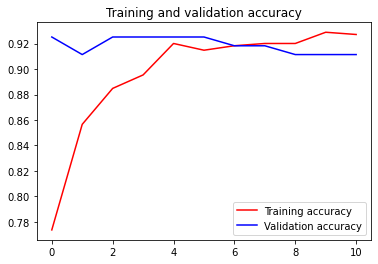

In [83]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()